In [4]:
%load_ext autoreload
%autoreload 2

import torch

from pianogen.model.model import SelectiveAttnTransformer
from torch.optim import Adam
from torch import nn
from pianogen.dataset.with_feature import FeatureDataset
from pianogen.tokenizer import PianoRollTokenizer
from torch.utils.data import DataLoader
from pianogen.model.with_feature import Cake

device = 'cuda'

def move_to_device(b):
    if isinstance(b, torch.Tensor):
        return b.to(device)
    elif isinstance(b, dict):
        return {k:move_to_device(v) for k,v in b.items()}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
model = Cake(a0_size=512, max_len=150, dim_model=256, num_layers=6, num_heads=8, dim_feedforward=1024)
model = model.to(device).train()

# ds = FeatureDataset(r'W:\music\music-data-analysis\data', loaders=model.get_loaders(), max_duration=32*150)
# dl = DataLoader(ds,batch_size=3, shuffle=True, num_workers=8)
# gradient_accumulation_steps = 3

ds = FeatureDataset(r'W:\music\music-data-analysis\data', loaders=model.get_loaders(), segment_len=32*16, hop_len=32)
dl = DataLoader(ds,batch_size=32, shuffle=True, num_workers=8)
gradient_accumulation_steps = 1

test_data = FeatureDataset.from_midi(r'W:\music\ai_cowork_trim.mid', loaders=model.get_loaders())

Loaded 251634 samples from 2570 songs


100%|██████████| 1/1 [00:00<00:00, 82.45it/s]

Loaded 1 samples from 1 songs


In [6]:
ds[0]['piano_roll']['indices'].shape

torch.Size([16, 150])

In [7]:
from pathlib import Path
from torch.utils.tensorboard.writer import SummaryWriter

exp_name = 'feature/16bar'

output_dir = Path(f'./output/{exp_name}')
output_dir.mkdir(parents=True, exist_ok=True)
checkpoint_dir = Path(f'./checkpoint/{exp_name}')
checkpoint_dir.mkdir(parents=True, exist_ok=True)
tensorboard_dir = Path(f'./tensorboard/{exp_name}')

writer = SummaryWriter(tensorboard_dir)
opt = Adam(model.parameters(), lr=2e-4)
print('number of parameters:', sum(p.numel() for p in model.parameters())/1e6, 'M')

number of parameters: 19.572441 M


In [9]:
from_epoch = 125823
epoch = from_epoch
# load from checkpoint
if from_epoch > 0:
    checkpoint = torch.load(checkpoint_dir/f'{from_epoch}.pt')
    model.load_state_dict(checkpoint['model'])
    opt.load_state_dict(checkpoint['opt'])
model = model.to(device)

In [8]:
# train
from pianogen import gpu_temp_control
from tqdm import tqdm

temp_control = gpu_temp_control.GPUTempControl(64,3)

model.to(device)

model.train()

for epoch in range(from_epoch+1,400): 
    tq = tqdm(dl)
    model.train()
    for i, batch in enumerate(tq): 
        frac_epoch = (epoch-1) + i/len(dl)
        steps = (epoch-1) * len(dl) + i
        batch = move_to_device(batch)
        assert isinstance(batch, dict)
        loss = model.calculate_loss(batch)
        loss['total'].backward()

        if (i+1) % gradient_accumulation_steps == 0:
            opt.step()
            opt.zero_grad()

        temp_control.cooldown()

        if i % 10 == 0:
            # print the loss to tqdm
            tq.set_postfix(batch = i, loss= loss, gpu_temp=temp_control.get_temp())
        
        if torch.isnan(loss['total']):
            raise ValueError("Loss is NaN")

        # writer.add_scalar('loss', loss.item(), frac_epoch)
        for k,v in loss.items():
            writer.add_scalar(f'loss_{k}', v.item(), steps)
        writer.add_scalar('gpu_temp', temp_control.get_temp(), steps)

        if i in [len(dl)//16*i for i in range(1,17)]:
            model.eval()
            model.sample_and_save(output_dir/f'{steps}.mid', 16, 4)
            model.sample_and_save(output_dir/f'cont_{steps}.mid', 16, 4, test_data[0], 6)
            model.train()

    if epoch % 1 == 0:
        torch.save({'model':model.state_dict(), 'opt':opt.state_dict()}, checkpoint_dir/f'{steps}.pt')
    

100%|██████████| 16/16 [00:12<00:00,  1.24it/s]/s, batch=490, gpu_temp=58, loss={'chord': tensor(1.6553, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.5305, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.1991, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.5505, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.4335, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(7.3689, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 14}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 45}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'C_M', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m', 'D_m', 'D_m', 'D_m']


  6%|▋         | 492/7864 [03:57<12:18:05,  6.01s/it, batch=490, gpu_temp=58, loss={'chord': tensor(1.6553, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.5305, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.1991, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.5505, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.4335, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(7.3689, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m']


100%|██████████| 16/16 [00:12<00:00,  1.31it/s]/s, batch=980, gpu_temp=59, loss={'chord': tensor(1.5138, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.5870, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.2315, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.5942, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.3468, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(7.2733, device='cuda:0', grad_fn=<AddBackward0>)}]   


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_sus2', 'F_sus2', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M']


 12%|█▎        | 983/7864 [07:17<10:33:52,  5.53s/it, batch=980, gpu_temp=59, loss={'chord': tensor(1.5138, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.5870, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.2315, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.5942, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.3468, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(7.2733, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'G_M', 'G_M', 'E_m7', 'E_m7']


100%|██████████| 16/16 [00:13<00:00,  1.19it/s]t/s, batch=1470, gpu_temp=56, loss={'chord': tensor(1.4749, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.3877, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.1093, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.3001, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2302, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.5022, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  ['next_frame', {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 19}]
Chords:  ['F_M7', 'F_M7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F_M', 'F_M', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F_M', 'F_M', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


 19%|█▊        | 1474/7864 [10:50<10:41:45,  6.03s/it, batch=1470, gpu_temp=56, loss={'chord': tensor(1.4749, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.3877, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.1093, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.3001, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2302, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.5022, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_sus2', 'F_sus2', 'F_M', 'F_M']


100%|██████████| 16/16 [00:12<00:00,  1.32it/s]t/s, batch=1960, gpu_temp=61, loss={'chord': tensor(1.6131, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.5218, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.2544, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.4065, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.3204, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(7.1161, device='cuda:0', grad_fn=<AddBackward0>)}]   


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 20}]
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'G_7', 'G_7', 'G_7', 'G_7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_m', 'E_m', 'E_m', 'E_m']


 25%|██▍       | 1965/7864 [14:15<9:15:59,  5.66s/it, batch=1960, gpu_temp=61, loss={'chord': tensor(1.6131, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.5218, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.2544, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.4065, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.3204, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(7.1161, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'F_M', 'F_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:10<00:00,  1.46it/s]t/s, batch=2450, gpu_temp=55, loss={'chord': tensor(1.3273, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.4479, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.1645, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.3878, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2595, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.5870, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 8}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 16}]
Chords:  ['A#_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'C_m7', 'C_m7', 'C_m7', 'C_m7', 'D#_M7', 'D#_M7', 'C_m7', 'C_m7', 'A#_7', 'A#_7', 'C_m7', 'C_m7', 'C_m7', 'C_m7', 'C_m7', 'C_m7', 'A#_M', 'D#_M7', 'A#_M', 'A#_M', 'G#_M7', 'G#_M7', 'A#_M', 'A#_M']


 31%|███       | 2456/7864 [17:41<7:22:27,  4.91s/it, batch=2450, gpu_temp=55, loss={'chord': tensor(1.3273, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.4479, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.1645, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.3878, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2595, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.5870, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]t/s, batch=2940, gpu_temp=59, loss={'chord': tensor(1.4567, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.3825, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.0581, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.2670, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2358, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.4001, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 63}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['F_m', 'F_m', 'F_m', 'F_m', 'D_m', 'D_m', 'D_o', 'D_o', 'G_7', 'G_7', 'G_7', 'G_7', 'G_7', 'G_7', 'G_7', 'G_7', 'G_7', 'G_7', 'G_M', 'G_M', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'C_M7', 'C_M7']


 37%|███▋      | 2947/7864 [21:02<9:06:55,  6.67s/it, batch=2940, gpu_temp=59, loss={'chord': tensor(1.4567, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.3825, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.0581, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.2670, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2358, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.4001, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:09<00:00,  1.64it/s]t/s, batch=3430, gpu_temp=61, loss={'chord': tensor(1.5032, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.5152, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.0683, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.4141, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2433, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.7442, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 14}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 14}]
Chords:  ['E_M', 'E_M', 'E_M', 'E_M', 'A_M7', 'A_M7', 'A_M7', 'A_M7', 'E_M', 'E_M', 'E_M', 'E_M', 'A_M', 'A_M', 'A_M', 'A_M', 'A_M7', 'A_M7', 'A_M7', 'A_M7', 'C#_m', 'A_M', 'C#_m', 'C#_m', 'C#_m7', 'C#_m7', 'F#_m7', 'F#_m7', 'D#_o', 'D#_o', 'D#_o', 'D#_o']


 44%|████▎     | 3438/7864 [23:53<5:19:21,  4.33s/it, batch=3430, gpu_temp=61, loss={'chord': tensor(1.5032, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.5152, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.0683, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.4141, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2433, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.7442, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'F_M', 'C_M', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:13<00:00,  1.19it/s]t/s, batch=3920, gpu_temp=61, loss={'chord': tensor(1.3549, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.4847, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.1501, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.3308, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2049, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.5253, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 40}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 52}, {'type': 'velocity', 'value': 21}]
Chords:  ['F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m', 'D_m', 'D_m7', 'D_m7', 'G_7', 'G_7', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


 50%|████▉     | 3929/7864 [26:53<6:55:03,  6.33s/it, batch=3920, gpu_temp=61, loss={'chord': tensor(1.3549, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.4847, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.1501, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.3308, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2049, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.5253, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_sus4', 'G_sus4', 'C_M', 'C_M']


100%|██████████| 16/16 [00:11<00:00,  1.44it/s]t/s, batch=4410, gpu_temp=60, loss={'chord': tensor(1.2713, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.2680, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.1030, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.2722, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1738, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.0883, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M']


 56%|█████▌    | 4420/7864 [30:20<5:17:54,  5.54s/it, batch=4410, gpu_temp=60, loss={'chord': tensor(1.2713, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.2680, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.1030, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.2722, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1738, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.0883, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:13<00:00,  1.16it/s]t/s, batch=4910, gpu_temp=60, loss={'chord': tensor(1.3396, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.3659, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.9905, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.3101, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2340, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.2400, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'G_M', 'G_M', 'C_M7', 'C_M7', 'G_7', 'G_7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'D_m7', 'D_m7', 'G_sus4', 'G_sus4', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'C_M7', 'C_M7', 'G_M', 'G_M']


 62%|██████▏   | 4911/7864 [33:50<4:53:47,  5.97s/it, batch=4910, gpu_temp=60, loss={'chord': tensor(1.3396, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.3659, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.9905, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.3101, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2340, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.2400, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:18<00:00,  1.15s/it]t/s, batch=5400, gpu_temp=61, loss={'chord': tensor(1.3382, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.2127, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.0509, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.2333, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2159, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.0510, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 56}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['D_M', 'D_M', 'E_m7', 'E_m7', 'E_m', 'E_m', 'E_m7', 'E_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'E_7', 'E_7', 'E_7', 'E_7']


 69%|██████▊   | 5402/7864 [36:56<5:19:06,  7.78s/it, batch=5400, gpu_temp=61, loss={'chord': tensor(1.3382, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.2127, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.0509, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.2333, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2159, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.0510, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:09<00:00,  1.74it/s]t/s, batch=5890, gpu_temp=56, loss={'chord': tensor(1.3023, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.3320, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.0129, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.2360, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1521, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.0354, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['G_M', 'G_M', 'G_M', 'G_M', 'E_m', 'E_m', 'E_m7', 'E_m7', 'A_M', 'A_M', 'A_M', 'A_M', 'D_M', 'D_M', 'D_M', 'D_M', 'D_M', 'D_M', 'D_M', 'D_M', 'D_m', 'D_m', 'D_m', 'D_m', 'G_M', 'G_M', 'G_M', 'G_M', 'E_m', 'E_m', 'E_m7', 'E_m7']


 75%|███████▍  | 5893/7864 [40:07<2:24:39,  4.40s/it, batch=5890, gpu_temp=56, loss={'chord': tensor(1.3023, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.3320, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.0129, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.2360, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1521, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.0354, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]t/s, batch=6380, gpu_temp=62, loss={'chord': tensor(1.3134, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.3469, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.0952, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.2648, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2081, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.2284, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}]
Chords:  ['E_m7', 'E_m7', 'E_m', 'E_m', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'E_m7', 'E_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M']


 81%|████████  | 6384/7864 [42:52<1:48:08,  4.38s/it, batch=6380, gpu_temp=62, loss={'chord': tensor(1.3134, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.3469, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(1.0952, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.2648, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2081, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.2284, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:09<00:00,  1.62it/s]t/s, batch=6870, gpu_temp=62, loss={'chord': tensor(1.2879, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.2520, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.8914, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.1009, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1800, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.7122, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'D_7', 'D_7', 'B_m7', 'B_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_sus2', 'A_sus2', 'A_sus2', 'A_sus2', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_sus2', 'A_sus2', 'A_sus2', 'A_sus2']


 87%|████████▋ | 6875/7864 [45:38<1:18:53,  4.79s/it, batch=6870, gpu_temp=62, loss={'chord': tensor(1.2879, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.2520, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.8914, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.1009, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1800, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.7122, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:14<00:00,  1.07it/s]t/s, batch=7360, gpu_temp=57, loss={'chord': tensor(1.2582, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.2577, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.9593, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.3626, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1660, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.0038, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 10}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 25}, {'type': 'pitch', 'value': 65}, {'type': 'velocity', 'value': 26}, 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m', 'A_m', 'F_M7', 'F_M7', 'C_M', 'C_M', 'G_M', 'G_M']


 94%|█████████▎| 7366/7864 [48:44<56:21,  6.79s/it, batch=7360, gpu_temp=57, loss={'chord': tensor(1.2582, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.2577, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.9593, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.3626, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1660, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.0038, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]t/s, batch=7850, gpu_temp=61, loss={'chord': tensor(1.4183, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.2701, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.9240, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.1999, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2101, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.0224, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 8}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 19}]
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M', 'F_M', 'E_7', 'E_7', 'E_7', 'E_7', 'A_m', 'A_m', 'A_m', 'A_m']


100%|█████████▉| 7857/7864 [52:01<00:46,  6.62s/it, batch=7850, gpu_temp=61, loss={'chord': tensor(1.4183, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.2701, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.9240, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.1999, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2101, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.0224, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:10<00:00,  1.51it/s]/s, batch=490, gpu_temp=64, loss={'chord': tensor(1.4512, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.4025, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.9232, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.2077, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2395, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.2241, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_7', 'G_7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M7', 'C_M7']


  6%|▋         | 492/7864 [03:07<11:03:58,  5.40s/it, batch=490, gpu_temp=64, loss={'chord': tensor(1.4512, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.4025, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.9232, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.2077, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2395, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(6.2241, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:10<00:00,  1.50it/s]/s, batch=980, gpu_temp=63, loss={'chord': tensor(1.1676, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.1044, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.8442, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.9942, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1295, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.2399, device='cuda:0', grad_fn=<AddBackward0>)}]   


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame']
Chords:  ['F_M7', 'F_M7', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'A_m7', 'A_m7', 'C_M', 'C_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'A_m', 'A_m', 'C_M', 'C_M', 'F_M', 'F_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'C_M', 'C_M']


 12%|█▎        | 983/7864 [05:55<9:38:35,  5.05s/it, batch=980, gpu_temp=63, loss={'chord': tensor(1.1676, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.1044, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.8442, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.9942, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1295, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.2399, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:13<00:00,  1.17it/s]t/s, batch=1470, gpu_temp=61, loss={'chord': tensor(1.3182, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.1946, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.9196, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.9743, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1047, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.5113, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 24}, {'type': 'pitch', 'value': 63}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M', 'F_M']


 19%|█▊        | 1474/7864 [09:00<10:35:30,  5.97s/it, batch=1470, gpu_temp=61, loss={'chord': tensor(1.3182, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.1946, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.9196, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.9743, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1047, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.5113, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:13<00:00,  1.17it/s]t/s, batch=1960, gpu_temp=60, loss={'chord': tensor(1.3868, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.1433, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.9146, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.0255, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0998, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.5699, device='cuda:0', grad_fn=<AddBackward0>)}]   


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['D_m7', 'D_m7', 'D_m7', 'D_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m', 'D_m', 'D_m', 'D_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m', 'D_m', 'A_m', 'A_m']


 25%|██▍       | 1965/7864 [12:00<9:45:11,  5.95s/it, batch=1960, gpu_temp=60, loss={'chord': tensor(1.3868, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.1433, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.9146, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.0255, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0998, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.5699, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:09<00:00,  1.62it/s]t/s, batch=2450, gpu_temp=61, loss={'chord': tensor(1.2957, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.3000, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.9227, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.9338, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2314, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.6836, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 42}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 42}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 15}]
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'E_m', 'E_m', 'E_m', 'E_m', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


 31%|███       | 2456/7864 [14:55<7:16:32,  4.84s/it, batch=2450, gpu_temp=61, loss={'chord': tensor(1.2957, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.3000, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.9227, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.9338, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2314, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.6836, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_sus2', 'F_sus2', 'F_M', 'F_M']


100%|██████████| 16/16 [00:10<00:00,  1.49it/s]t/s, batch=2940, gpu_temp=61, loss={'chord': tensor(1.2286, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.1974, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.8886, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.0570, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1201, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.4916, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_M', 'A_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_M', 'A_M', 'A_M', 'A_M', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_M', 'A_M', 'A_M', 'A_M']


 37%|███▋      | 2947/7864 [17:38<6:36:41,  4.84s/it, batch=2940, gpu_temp=61, loss={'chord': tensor(1.2286, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.1974, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.8886, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.0570, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1201, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.4916, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:10<00:00,  1.49it/s]t/s, batch=3430, gpu_temp=61, loss={'chord': tensor(1.2709, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.1730, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.7443, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.0330, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1487, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.3698, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['G_7', 'G_7', 'G_7', 'G_7', 'A_7', 'A_7', 'A_m', 'A_m', 'A_sus4', 'A_sus4', 'A_m', 'A_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_7', 'G_7', 'G_7', 'G_7', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'E_m7', 'E_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


 44%|████▎     | 3438/7864 [20:26<6:17:28,  5.12s/it, batch=3430, gpu_temp=61, loss={'chord': tensor(1.2709, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.1730, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.7443, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.0330, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1487, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.3698, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_m7', 'G_m7', 'G_m7', 'G_m7']


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]t/s, batch=3920, gpu_temp=61, loss={'chord': tensor(1.2581, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.1839, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.7733, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.9605, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1739, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.3497, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 16}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 21}]
Chords:  ['E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'A_M7', 'A_M7', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M']


 50%|████▉     | 3929/7864 [23:15<5:53:44,  5.39s/it, batch=3920, gpu_temp=61, loss={'chord': tensor(1.2581, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.1839, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.7733, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.9605, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1739, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.3497, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_sus2', 'F_sus2', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]t/s, batch=4410, gpu_temp=63, loss={'chord': tensor(1.3660, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.1664, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.7900, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.0303, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1409, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.4938, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M']


 56%|█████▌    | 4420/7864 [25:56<3:50:44,  4.02s/it, batch=4410, gpu_temp=63, loss={'chord': tensor(1.3660, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.1664, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.7900, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(1.0303, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1409, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.4938, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:08<00:00,  1.80it/s]t/s, batch=4910, gpu_temp=63, loss={'chord': tensor(1.2042, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.0653, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.7571, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.9856, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2097, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.2219, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'E_7', 'E_7', 'E_7', 'E_7', 'A_m', 'A_m', 'A_m', 'A_m', 'G_m7', 'G_m7', 'G_m', 'G_m', 'A_m7', 'A_m7', 'None', 'None', 'G_m7', 'G_m7', 'C_7', 'C_7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'D_o', 'D_o', 'D_o', 'D_o']


 62%|██████▏   | 4911/7864 [28:39<3:26:34,  4.20s/it, batch=4910, gpu_temp=63, loss={'chord': tensor(1.2042, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.0653, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.7571, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.9856, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2097, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.2219, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:08<00:00,  1.79it/s]t/s, batch=5400, gpu_temp=56, loss={'chord': tensor(1.2993, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.0391, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.7262, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.8292, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0727, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.9664, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 65}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['C_+', 'C_+', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'D_m', 'D_m', 'G_7', 'G_7', 'G_M', 'G_M', 'G_7', 'G_7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'G_7', 'G_7']


 69%|██████▊   | 5402/7864 [31:23<3:00:28,  4.40s/it, batch=5400, gpu_temp=56, loss={'chord': tensor(1.2993, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.0391, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.7262, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.8292, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0727, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.9664, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_7', 'G_7']


100%|██████████| 16/16 [00:08<00:00,  1.85it/s]t/s, batch=5890, gpu_temp=56, loss={'chord': tensor(1.1665, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.9969, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6495, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.8023, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1167, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.7320, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 24}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 24}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 63}, {'type': 'velocity', 'value': 24}]
Chords:  ['D_m7', 'D_m7', 'D_m7', 'D_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_sus2', 'C_sus2', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7']


 75%|███████▍  | 5893/7864 [34:10<2:51:37,  5.22s/it, batch=5890, gpu_temp=56, loss={'chord': tensor(1.1665, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.9969, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6495, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.8023, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1167, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.7320, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]t/s, batch=6380, gpu_temp=61, loss={'chord': tensor(1.2545, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.0446, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.7678, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.8295, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1070, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.0034, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 10}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_sus2', 'C_sus2', 'A_o', 'A_o', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_sus4', 'G_sus4', 'C_M', 'C_M', 'A_m7', 'A_m7', 'C_M', 'C_M', 'A_o', 'A_o', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_sus4', 'G_sus4']


 81%|████████  | 6384/7864 [37:13<2:30:55,  6.12s/it, batch=6380, gpu_temp=61, loss={'chord': tensor(1.2545, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.0446, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.7678, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.8295, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1070, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(5.0034, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]t/s, batch=6870, gpu_temp=57, loss={'chord': tensor(1.1927, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.9643, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6781, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.8315, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1648, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.8313, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['E_7', 'E_7', 'E_7', 'E_7', 'A_m', 'A_m', 'A_m', 'A_m', 'D_M', 'D_M', 'D_M', 'D_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'E_7', 'E_7', 'E_M', 'E_M', 'C_+', 'C_+', 'C_M', 'C_M', 'F#_o', 'F#_o', 'F#_o', 'F#_o']


 87%|████████▋ | 6875/7864 [40:07<1:09:47,  4.23s/it, batch=6870, gpu_temp=57, loss={'chord': tensor(1.1927, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.9643, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6781, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.8315, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1648, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.8313, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M']


100%|██████████| 16/16 [00:09<00:00,  1.68it/s]t/s, batch=7360, gpu_temp=63, loss={'chord': tensor(1.0029, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.9479, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6126, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6732, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1580, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.3947, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 20}]
Chords:  ['F_M7', 'F_M7', 'C_M7', 'C_M7', 'A_m', 'A_m', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'F_M7', 'F_M7']


 94%|█████████▎| 7366/7864 [42:52<35:08,  4.23s/it, batch=7360, gpu_temp=63, loss={'chord': tensor(1.0029, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.9479, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6126, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6732, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1580, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.3947, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_7', 'G_7']


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]t/s, batch=7850, gpu_temp=62, loss={'chord': tensor(1.1774, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.0279, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6902, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.9119, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0876, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.8949, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 23}]
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'C_M', 'C_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M']


100%|█████████▉| 7857/7864 [45:37<00:30,  4.33s/it, batch=7850, gpu_temp=62, loss={'chord': tensor(1.1774, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(1.0279, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6902, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.9119, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0876, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.8949, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_7', 'G_7']


100%|██████████| 16/16 [00:08<00:00,  1.80it/s]/s, batch=490, gpu_temp=62, loss={'chord': tensor(1.1558, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.9772, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6110, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.8134, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2152, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.7726, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 24}, {'type': 'pitch', 'value': 63}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame']
Chords:  ['D_m', 'D_m', 'D_m', 'D_m', 'D_m7', 'D_m7', 'F_M', 'F_M', 'G_sus4', 'G_sus4', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M']


  6%|▋         | 492/7864 [02:56<9:14:47,  4.52s/it, batch=490, gpu_temp=62, loss={'chord': tensor(1.1558, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.9772, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6110, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.8134, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2152, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.7726, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:13<00:00,  1.21it/s]/s, batch=980, gpu_temp=61, loss={'chord': tensor(1.2569, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.8964, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6617, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.8237, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2125, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.8512, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame']
Chords:  ['F_M7', 'F_M7', 'G_7', 'G_7', 'F_M', 'F_M', 'G_7', 'G_7', 'A_m', 'A_m', 'C_+', 'C_+', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M', 'D_m7', 'D_m7', 'E_7', 'E_7', 'A_m', 'A_m', 'A_m', 'A_m', 'G_M', 'G_M', 'G_M', 'G_M']


 12%|█▎        | 983/7864 [05:45<11:15:43,  5.89s/it, batch=980, gpu_temp=61, loss={'chord': tensor(1.2569, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.8964, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6617, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.8237, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2125, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.8512, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M']


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]t/s, batch=1470, gpu_temp=62, loss={'chord': tensor(1.0774, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.8718, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.5852, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.7408, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0506, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.3259, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 22}]
Chords:  ['A_M', 'A_M', 'A_M', 'A_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_M', 'A_M', 'A_M', 'A_M', 'A_m', 'A_m', 'A_M', 'A_M', 'A_M', 'A_M', 'A_M', 'A_M', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']


 19%|█▊        | 1474/7864 [08:33<7:59:27,  4.50s/it, batch=1470, gpu_temp=62, loss={'chord': tensor(1.0774, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.8718, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.5852, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.7408, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0506, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.3259, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:09<00:00,  1.76it/s]t/s, batch=1960, gpu_temp=56, loss={'chord': tensor(1.1963, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.9766, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6562, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.7369, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1539, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.7200, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'C_M', 'C_M', 'C_M', 'C_M']


 25%|██▍       | 1965/7864 [11:16<6:57:43,  4.25s/it, batch=1960, gpu_temp=56, loss={'chord': tensor(1.1963, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.9766, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6562, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.7369, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1539, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.7200, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:10<00:00,  1.46it/s]t/s, batch=2450, gpu_temp=56, loss={'chord': tensor(1.1305, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.9449, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6789, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.7392, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0908, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.5843, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_M7', 'A_M7', 'B_m7', 'B_m7', 'D_M', 'D_M', 'D_M7', 'D_M7', 'A_M', 'A_M', 'A_M', 'A_M', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'B_m7', 'B_m7', 'D_M', 'D_M', 'E_m', 'E_m', 'G_M', 'G_M', 'A_M', 'A_M', 'A_M', 'A_M']


 31%|███       | 2456/7864 [14:01<7:31:03,  5.00s/it, batch=2450, gpu_temp=56, loss={'chord': tensor(1.1305, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.9449, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6789, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.7392, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0908, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.5843, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:10<00:00,  1.53it/s]t/s, batch=2940, gpu_temp=63, loss={'chord': tensor(1.2357, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.9087, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6620, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.7841, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0988, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.6893, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 17}]
Chords:  ['A_M', 'A_M', 'A_m', 'A_m', 'E_7', 'E_7', 'E_7', 'E_7', 'E_7', 'E_7', 'E_7', 'E_7', 'E_7', 'E_7', 'E_7', 'E_7', 'A_M', 'A_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'F_M', 'F_M']


 37%|███▋      | 2947/7864 [16:43<6:56:53,  5.09s/it, batch=2940, gpu_temp=63, loss={'chord': tensor(1.2357, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.9087, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6620, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.7841, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0988, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.6893, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:09<00:00,  1.69it/s]t/s, batch=3430, gpu_temp=61, loss={'chord': tensor(1.0819, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.8247, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4701, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6180, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0570, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.0516, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_m', 'F_m', 'D_m', 'D_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_o', 'D_o', 'F_m', 'F_m', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'E_m', 'E_m', 'E_m', 'E_m', 'E_m', 'E_m', 'E_m', 'E_m']


 44%|████▎     | 3438/7864 [19:24<5:24:10,  4.39s/it, batch=3430, gpu_temp=61, loss={'chord': tensor(1.0819, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.8247, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4701, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6180, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0570, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.0516, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:10<00:00,  1.56it/s]t/s, batch=3920, gpu_temp=56, loss={'chord': tensor(1.3064, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.8484, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6751, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.7524, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1498, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.7323, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 17}]
Chords:  ['None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'D_m7', 'D_m7', 'G_m7', 'G_m7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M7', 'C_M7']


 50%|████▉     | 3929/7864 [22:10<5:09:59,  4.73s/it, batch=3920, gpu_temp=56, loss={'chord': tensor(1.3064, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.8484, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6751, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.7524, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1498, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.7323, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:13<00:00,  1.23it/s]t/s, batch=4410, gpu_temp=56, loss={'chord': tensor(1.1415, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.8100, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.5552, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.7129, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1840, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.4036, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 16}]
Chords:  ['G_M', 'G_M', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M', 'F_M']


 56%|█████▌    | 4420/7864 [25:02<5:26:11,  5.68s/it, batch=4410, gpu_temp=56, loss={'chord': tensor(1.1415, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.8100, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.5552, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.7129, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1840, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.4036, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:09<00:00,  1.63it/s]t/s, batch=4910, gpu_temp=56, loss={'chord': tensor(1.2616, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7557, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6134, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6613, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1508, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.4427, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'A_M', 'A_M', 'A_m', 'A_m', 'D_m7', 'D_m7', 'D_m', 'D_m', 'D_m7', 'D_m7', 'D_m', 'D_m', 'D_m', 'D_m', 'D_m', 'D_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m']


 62%|██████▏   | 4911/7864 [27:47<3:40:56,  4.49s/it, batch=4910, gpu_temp=56, loss={'chord': tensor(1.2616, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7557, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.6134, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6613, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1508, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.4427, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:09<00:00,  1.62it/s]t/s, batch=5400, gpu_temp=62, loss={'chord': tensor(1.2187, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7898, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4912, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6501, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0518, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.2016, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame']
Chords:  ['D_m', 'D_m', 'G_7', 'G_7', 'F_M', 'F_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'D_m', 'D_m', 'D_m', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M']


 69%|██████▊   | 5402/7864 [30:40<3:08:12,  4.59s/it, batch=5400, gpu_temp=62, loss={'chord': tensor(1.2187, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7898, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4912, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6501, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0518, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.2016, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m', 'D_m']


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]t/s, batch=5890, gpu_temp=61, loss={'chord': tensor(1.2360, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.8154, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.5803, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6764, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1388, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.4469, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 67}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M']


 75%|███████▍  | 5893/7864 [33:23<2:26:52,  4.47s/it, batch=5890, gpu_temp=61, loss={'chord': tensor(1.2360, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.8154, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.5803, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6764, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1388, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.4469, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:13<00:00,  1.21it/s]t/s, batch=6380, gpu_temp=61, loss={'chord': tensor(1.1629, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7116, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4984, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6131, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0644, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.0504, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 18}]
Chords:  ['B_o', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'None', 'None', 'A_m', 'A_m', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'F_M', 'F_M', 'G_7', 'G_7', 'E_M', 'E_M', 'A_m', 'A_m']


 81%|████████  | 6384/7864 [36:12<2:51:31,  6.95s/it, batch=6380, gpu_temp=61, loss={'chord': tensor(1.1629, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7116, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4984, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6131, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0644, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.0504, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]t/s, batch=6870, gpu_temp=62, loss={'chord': tensor(1.0251, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.8664, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4815, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6293, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0722, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.0745, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'A_m', 'A_m', 'A_m', 'A_m', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M']


 87%|████████▋ | 6875/7864 [38:55<1:32:13,  5.60s/it, batch=6870, gpu_temp=62, loss={'chord': tensor(1.0251, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.8664, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4815, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6293, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0722, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.0745, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:14<00:00,  1.12it/s]t/s, batch=7360, gpu_temp=61, loss={'chord': tensor(1.0493, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7735, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.5280, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5748, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0292, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.9549, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  ['next_frame', {'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 39}]
Chords:  ['F_M7', 'F_M7', 'F_M', 'F_M', 'E_m', 'E_m', 'E_m', 'E_m', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'D_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m']


 94%|█████████▎| 7366/7864 [41:56<54:20,  6.55s/it, batch=7360, gpu_temp=61, loss={'chord': tensor(1.0493, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7735, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.5280, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5748, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0292, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.9549, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:17<00:00,  1.11s/it]t/s, batch=7850, gpu_temp=61, loss={'chord': tensor(1.0535, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7472, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.5484, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6124, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0730, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.0346, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 24}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['G_M', 'G_M', 'G_M', 'G_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'A_M', 'A_M', 'A_sus4', 'A_sus4', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']


100%|█████████▉| 7857/7864 [45:09<00:52,  7.53s/it, batch=7850, gpu_temp=61, loss={'chord': tensor(1.0535, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7472, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.5484, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6124, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0730, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.0346, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:11<00:00,  1.37it/s]/s, batch=490, gpu_temp=61, loss={'chord': tensor(1.1141, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7495, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.5033, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6342, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0660, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.0670, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 21}]
Chords:  ['D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_sus4', 'G_sus4', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_7', 'G_7', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M']


  6%|▋         | 492/7864 [03:06<11:00:56,  5.38s/it, batch=490, gpu_temp=61, loss={'chord': tensor(1.1141, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7495, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.5033, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6342, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0660, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.0670, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:10<00:00,  1.50it/s]/s, batch=980, gpu_temp=56, loss={'chord': tensor(1.1147, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7298, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4797, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6999, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0331, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.0571, device='cuda:0', grad_fn=<AddBackward0>)}]   


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m7', 'A_m7', 'F_M', 'F_M', 'C_M', 'C_M', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'C_M', 'C_M', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'D_m7', 'D_m7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'C_M', 'C_M']


 12%|█▎        | 983/7864 [05:59<9:29:50,  4.97s/it, batch=980, gpu_temp=56, loss={'chord': tensor(1.1147, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7298, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4797, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6999, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0331, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.0571, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_o', 'A_o', 'A_o', 'A_o', 'A_o', 'A_o', 'A_o', 'A_o']


100%|██████████| 16/16 [00:09<00:00,  1.64it/s]t/s, batch=1470, gpu_temp=63, loss={'chord': tensor(1.2660, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7302, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4599, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5967, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1040, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.1569, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 22}]
Chords:  ['C_M', 'C_M', 'A_m7', 'A_m7', 'A_M', 'A_M', 'A_M', 'A_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_M', 'A_M', 'A_7', 'A_7', 'A_m', 'A_m', 'A_m', 'A_m', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'D_m7', 'D_m7']


 19%|█▊        | 1474/7864 [08:57<8:02:14,  4.53s/it, batch=1470, gpu_temp=63, loss={'chord': tensor(1.2660, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7302, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4599, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5967, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1040, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.1569, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M']


100%|██████████| 16/16 [00:10<00:00,  1.57it/s]t/s, batch=1960, gpu_temp=56, loss={'chord': tensor(0.9906, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6948, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.5262, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5651, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0439, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.8208, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 5}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 5}, {'type': 'velocity', 'value': 18}]
Chords:  ['D_m7', 'D_m7', 'E_m', 'E_m', 'A_m7', 'A_m7', 'A_sus2', 'A_sus2', 'F_M7', 'F_M7', 'E_m', 'E_m', 'A_sus2', 'A_sus2', 'A_sus2', 'A_sus2', 'F_M', 'F_M', 'E_m', 'E_m', 'A_m7', 'A_m7', 'A_M', 'A_M', 'F_sus2', 'F_sus2', 'C_M', 'C_M', 'F_M7', 'F_M7', 'E_m7', 'E_m7']


 25%|██▍       | 1965/7864 [11:40<7:32:50,  4.61s/it, batch=1960, gpu_temp=56, loss={'chord': tensor(0.9906, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6948, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.5262, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5651, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0439, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.8208, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:12<00:00,  1.30it/s]t/s, batch=2450, gpu_temp=60, loss={'chord': tensor(1.1717, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6363, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4059, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4805, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1049, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.7992, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 8}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'E_7', 'E_7', 'E_7', 'E_7', 'A_m', 'A_m', 'A_m', 'A_m', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M7', 'F_M7', 'E_m', 'E_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


 31%|███       | 2456/7864 [14:37<8:28:57,  5.65s/it, batch=2450, gpu_temp=60, loss={'chord': tensor(1.1717, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6363, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4059, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4805, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1049, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.7992, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:10<00:00,  1.51it/s]t/s, batch=2940, gpu_temp=61, loss={'chord': tensor(1.1511, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6431, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4246, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5603, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1233, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.9025, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 24}, {'type': 'pitch', 'value': 62}, {'type': 'velocity', 'value': 25}, 'next_frame', 'next_frame']
Chords:  ['C_+', 'C_+', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_7', 'G_7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M7', 'F_M7']


 37%|███▋      | 2947/7864 [17:51<7:39:46,  5.61s/it, batch=2940, gpu_temp=61, loss={'chord': tensor(1.1511, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6431, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4246, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5603, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1233, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.9025, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:13<00:00,  1.20it/s]t/s, batch=3430, gpu_temp=60, loss={'chord': tensor(1.2429, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7343, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4138, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6063, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2476, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.2449, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 21}]
Chords:  ['D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M']


 44%|████▎     | 3438/7864 [21:06<7:24:24,  6.02s/it, batch=3430, gpu_temp=60, loss={'chord': tensor(1.2429, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7343, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4138, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6063, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.2476, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.2449, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]t/s, batch=3920, gpu_temp=61, loss={'chord': tensor(0.9624, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7136, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3929, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5821, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9999, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.6509, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 18}]
Chords:  ['D_m', 'D_m', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M7', 'C_M7', 'E_m', 'E_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_sus2', 'F_sus2']


 50%|████▉     | 3929/7864 [23:58<6:55:48,  6.34s/it, batch=3920, gpu_temp=61, loss={'chord': tensor(0.9624, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7136, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3929, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5821, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9999, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.6509, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:14<00:00,  1.11it/s]t/s, batch=4410, gpu_temp=61, loss={'chord': tensor(1.1628, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6812, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4573, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5502, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1273, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.9788, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 56}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 63}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'F_M', 'F_M', 'G_7', 'G_7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'B_o', 'B_o', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'None', 'None', 'None', 'None']


 56%|█████▌    | 4420/7864 [26:55<6:04:24,  6.35s/it, batch=4410, gpu_temp=61, loss={'chord': tensor(1.1628, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6812, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4573, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5502, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1273, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.9788, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:08<00:00,  1.79it/s]t/s, batch=4910, gpu_temp=61, loss={'chord': tensor(0.9294, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6818, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4761, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5560, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0526, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.6960, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m7', 'A_m7', 'F_M', 'F_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'G_M', 'G_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'D_m', 'D_m', 'D_m7', 'D_m7', 'E_m7', 'E_m7', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M']


 62%|██████▏   | 4911/7864 [29:49<3:39:41,  4.46s/it, batch=4910, gpu_temp=61, loss={'chord': tensor(0.9294, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6818, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4761, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5560, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0526, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.6960, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:10<00:00,  1.47it/s]t/s, batch=5400, gpu_temp=62, loss={'chord': tensor(1.1601, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6758, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4356, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5346, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0573, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.8634, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 24}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 22}]
Chords:  ['G_M', 'G_M', 'C_M', 'C_M', 'D_7', 'D_7', 'G_7', 'G_7', 'A_m', 'A_m', 'C_M', 'C_M', 'D_7', 'D_7', 'D_M', 'D_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M', 'D_M', 'A_m', 'A_m', 'A_m', 'A_m']


 69%|██████▊   | 5402/7864 [32:35<3:16:24,  4.79s/it, batch=5400, gpu_temp=62, loss={'chord': tensor(1.1601, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6758, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4356, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5346, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0573, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.8634, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]t/s, batch=5890, gpu_temp=61, loss={'chord': tensor(1.1452, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7274, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4500, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6277, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0606, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.0108, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 19}]
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_M', 'A_M', 'A_M', 'A_M', 'A_M', 'A_M', 'A_M', 'A_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'G_7', 'G_7', 'A_m', 'A_m', 'A_m', 'A_m']


 75%|███████▍  | 5893/7864 [35:20<2:21:25,  4.31s/it, batch=5890, gpu_temp=61, loss={'chord': tensor(1.1452, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.7274, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4500, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.6277, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0606, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.0108, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:09<00:00,  1.72it/s]t/s, batch=6380, gpu_temp=61, loss={'chord': tensor(1.1549, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6447, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4461, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4296, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0900, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.7653, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame']
Chords:  ['F_M7', 'F_M7', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'F_M7', 'F_M7', 'A_m', 'C_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'D_m', 'D_m', 'C_M', 'C_M', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'C_M', 'C_M', 'C_M', 'C_M']


 81%|████████  | 6384/7864 [38:08<1:54:59,  4.66s/it, batch=6380, gpu_temp=61, loss={'chord': tensor(1.1549, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6447, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4461, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4296, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0900, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.7653, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]t/s, batch=6870, gpu_temp=57, loss={'chord': tensor(1.1044, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5990, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4301, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5766, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1226, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.8327, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 7}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 22}]
Chords:  ['G_M', 'G_M', 'E_m7', 'E_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'E_m', 'E_m', 'E_m', 'E_m', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


 87%|████████▋ | 6875/7864 [40:54<1:08:20,  4.15s/it, batch=6870, gpu_temp=57, loss={'chord': tensor(1.1044, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5990, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4301, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5766, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1226, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.8327, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:09<00:00,  1.61it/s]t/s, batch=7360, gpu_temp=61, loss={'chord': tensor(1.2427, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6189, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.5124, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5738, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1147, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.0624, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame']
Chords:  ['G_sus2', 'G_sus2', 'None', 'None', 'G_M', 'G_M', 'G_7', 'G_7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M']


 94%|█████████▎| 7366/7864 [43:43<38:56,  4.69s/it, batch=7360, gpu_temp=61, loss={'chord': tensor(1.2427, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6189, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.5124, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5738, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1147, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(4.0624, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:13<00:00,  1.16it/s]t/s, batch=7850, gpu_temp=56, loss={'chord': tensor(1.0388, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5377, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3881, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4547, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9682, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3875, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 52}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 23}]
Chords:  ['G_M', 'G_M', 'C_M7', 'C_M7', 'F_M', 'F_M', 'D_m7', 'D_m7', 'G_7', 'G_7', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|█████████▉| 7857/7864 [46:34<00:41,  5.86s/it, batch=7850, gpu_temp=56, loss={'chord': tensor(1.0388, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5377, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3881, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4547, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9682, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3875, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]/s, batch=490, gpu_temp=61, loss={'chord': tensor(1.2517, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6398, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3894, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4235, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0705, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.7749, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  ['next_frame', {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 23}, 'next_frame']
Chords:  ['D_M', 'D_M', 'D_M', 'D_M', 'D_M', 'D_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M', 'F_M']


  6%|▋         | 492/7864 [03:21<13:28:19,  6.58s/it, batch=490, gpu_temp=61, loss={'chord': tensor(1.2517, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6398, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3894, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4235, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0705, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.7749, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]/s, batch=980, gpu_temp=56, loss={'chord': tensor(1.0622, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5552, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3730, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4653, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1607, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.6165, device='cuda:0', grad_fn=<AddBackward0>)}]   


Generated:  [{'type': 'pitch', 'value': 10}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 22}]
Chords:  ['A_sus4', 'A_sus4', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_M', 'A_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m']


 12%|█▎        | 983/7864 [06:42<13:55:28,  7.29s/it, batch=980, gpu_temp=56, loss={'chord': tensor(1.0622, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5552, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3730, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4653, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1607, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.6165, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]t/s, batch=1470, gpu_temp=61, loss={'chord': tensor(1.0529, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5424, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3824, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3802, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0598, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.4177, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'E_m', 'E_m', 'C_M', 'C_M', 'D_m', 'D_m', 'D_m', 'D_m', 'D_m', 'D_m', 'D_m', 'D_m', 'G_M', 'G_M', 'G_M', 'G_M']


 19%|█▊        | 1474/7864 [10:02<13:21:48,  7.53s/it, batch=1470, gpu_temp=61, loss={'chord': tensor(1.0529, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5424, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3824, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3802, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0598, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.4177, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_7', 'G_7']


100%|██████████| 16/16 [00:14<00:00,  1.14it/s]t/s, batch=1960, gpu_temp=61, loss={'chord': tensor(0.9824, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6042, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4289, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5371, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0732, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.6258, device='cuda:0', grad_fn=<AddBackward0>)}]   


Generated:  [{'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['G_M', 'G_M', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_o', 'A_o', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M', 'F_M']


 25%|██▍       | 1965/7864 [13:16<10:15:56,  6.26s/it, batch=1960, gpu_temp=61, loss={'chord': tensor(0.9824, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6042, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4289, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5371, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0732, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.6258, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M']


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]t/s, batch=2450, gpu_temp=55, loss={'chord': tensor(1.0630, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5655, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4118, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5093, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1540, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.7035, device='cuda:0', grad_fn=<AddBackward0>)}]   


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_M', 'A_M', 'D_m7', 'D_m7', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_M', 'E_M', 'E_M', 'E_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


 31%|███       | 2456/7864 [16:37<10:08:54,  6.76s/it, batch=2450, gpu_temp=55, loss={'chord': tensor(1.0630, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5655, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4118, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5093, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1540, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.7035, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:16<00:00,  1.02s/it]t/s, batch=2940, gpu_temp=60, loss={'chord': tensor(1.0887, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6511, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4247, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4797, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1034, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.7477, device='cuda:0', grad_fn=<AddBackward0>)}]   


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['D_M', 'D_M', 'D_m', 'D_m', 'A_m', 'A_m', 'A_m', 'A_m', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'E_m', 'E_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m7', 'A_m7']


 37%|███▋      | 2947/7864 [19:57<9:13:53,  6.76s/it, batch=2940, gpu_temp=60, loss={'chord': tensor(1.0887, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6511, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4247, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4797, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1034, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.7477, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M', 'C_M']


100%|██████████| 16/16 [00:12<00:00,  1.32it/s]t/s, batch=3430, gpu_temp=55, loss={'chord': tensor(0.9734, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5944, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4312, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4520, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0553, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5062, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 14}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 56}, {'type': 'velocity', 'value': 23}]
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'A_M', 'A_M', 'A_M', 'A_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M']


 44%|████▎     | 3438/7864 [23:10<7:20:50,  5.98s/it, batch=3430, gpu_temp=55, loss={'chord': tensor(0.9734, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5944, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4312, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4520, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0553, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5062, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:08<00:00,  1.94it/s]t/s, batch=3920, gpu_temp=57, loss={'chord': tensor(1.0504, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6607, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3531, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4488, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0746, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5876, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 18}]
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_m', 'E_m', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'E_m', 'E_m', 'E_m', 'E_m']


 50%|████▉     | 3929/7864 [26:16<4:22:43,  4.01s/it, batch=3920, gpu_temp=57, loss={'chord': tensor(1.0504, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6607, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3531, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4488, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0746, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5876, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:10<00:00,  1.50it/s]t/s, batch=4410, gpu_temp=61, loss={'chord': tensor(1.1650, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5481, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3998, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5283, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1213, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.7625, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m', 'A_m', 'E_m', 'E_m', 'E_m', 'E_m', 'F_M7', 'F_M7', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m', 'A_m', 'E_M', 'E_M', 'E_m', 'E_m', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


 56%|█████▌    | 4420/7864 [29:12<4:55:17,  5.14s/it, batch=4410, gpu_temp=61, loss={'chord': tensor(1.1650, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5481, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3998, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5283, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1213, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.7625, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:09<00:00,  1.63it/s]t/s, batch=4910, gpu_temp=61, loss={'chord': tensor(1.0230, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5615, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4053, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4858, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1009, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5766, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 13}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 25}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 56}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 61}, {'type': 'velocity', 'value': 23}]
Chords:  ['G_M', 'G_M', 'D_M', 'D_M', 'E_m7', 'E_m7', 'B_m7', 'B_m7', 'F_M7', 'F_M7', 'C_+', 'C_+', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'D_M', 'D_M', 'D_M', 'D_M', 'D_M', 'D_M', 'D_M', 'D_M', 'G_7', 'G_7', 'G_7', 'G_7']


 62%|██████▏   | 4911/7864 [32:11<3:54:20,  4.76s/it, batch=4910, gpu_temp=61, loss={'chord': tensor(1.0230, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5615, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4053, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4858, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1009, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5766, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:13<00:00,  1.16it/s]t/s, batch=5400, gpu_temp=61, loss={'chord': tensor(1.0198, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5360, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3588, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4532, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1340, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5018, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 15}, 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m', 'A_m', 'C_M', 'C_M', 'C_sus2', 'C_sus2', 'D_m7', 'D_m7', 'F_M', 'F_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m', 'D_m', 'D_m7', 'D_m7', 'D_m', 'D_m', 'D_m7', 'D_m7', 'E_M', 'E_M', 'E_M', 'E_M']


 69%|██████▊   | 5402/7864 [35:10<4:19:17,  6.32s/it, batch=5400, gpu_temp=61, loss={'chord': tensor(1.0198, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5360, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3588, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4532, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1340, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5018, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:11<00:00,  1.39it/s]t/s, batch=5890, gpu_temp=61, loss={'chord': tensor(1.0339, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5779, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3990, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5486, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0555, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.6148, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}]
Chords:  ['F_M7', 'F_M7', 'E_m7', 'E_m7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'E_m', 'E_m', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'E_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'E_m', 'E_m', 'F_M', 'F_M']


 75%|███████▍  | 5893/7864 [38:04<2:56:20,  5.37s/it, batch=5890, gpu_temp=61, loss={'chord': tensor(1.0339, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5779, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3990, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5486, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0555, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.6148, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:09<00:00,  1.75it/s]t/s, batch=6380, gpu_temp=56, loss={'chord': tensor(1.0642, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5818, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3419, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4433, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1559, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5871, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M7', 'F_M7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M']


 81%|████████  | 6384/7864 [40:45<1:52:05,  4.54s/it, batch=6380, gpu_temp=56, loss={'chord': tensor(1.0642, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5818, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3419, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4433, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1559, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5871, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:11<00:00,  1.42it/s]t/s, batch=6870, gpu_temp=61, loss={'chord': tensor(1.0825, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5455, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3229, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4533, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1361, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5404, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_7', 'G_7', 'A_m', 'A_m', 'G_M', 'G_M']


 87%|████████▋ | 6875/7864 [43:36<1:24:55,  5.15s/it, batch=6870, gpu_temp=61, loss={'chord': tensor(1.0825, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5455, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3229, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4533, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1361, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5404, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:12<00:00,  1.33it/s]t/s, batch=7360, gpu_temp=63, loss={'chord': tensor(1.0435, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6071, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4362, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4658, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0443, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5968, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 56}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 65}, {'type': 'velocity', 'value': 23}]
Chords:  ['F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_sus2', 'F_sus2', 'F_sus2', 'F_sus2', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G#_+', 'G#_+', 'A_m', 'A_m', 'A_m7', 'A_m7']


 94%|█████████▎| 7366/7864 [46:30<46:22,  5.59s/it, batch=7360, gpu_temp=63, loss={'chord': tensor(1.0435, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.6071, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4362, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4658, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0443, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5968, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M7', 'C_M7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:10<00:00,  1.55it/s]t/s, batch=7850, gpu_temp=63, loss={'chord': tensor(1.2609, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5525, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3434, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4974, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1697, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.8239, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 22}]
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'G_7', 'G_7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_m', 'E_m', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|█████████▉| 7857/7864 [49:25<00:35,  5.02s/it, batch=7850, gpu_temp=63, loss={'chord': tensor(1.2609, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5525, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3434, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4974, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1697, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.8239, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:09<00:00,  1.74it/s]/s, batch=490, gpu_temp=57, loss={'chord': tensor(1.0891, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5573, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4015, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4431, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1231, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.6140, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'E_m7', 'E_m7', 'G_M', 'G_M']


  6%|▋         | 492/7864 [03:04<8:50:21,  4.32s/it, batch=490, gpu_temp=57, loss={'chord': tensor(1.0891, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5573, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.4015, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4431, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1231, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.6140, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:08<00:00,  1.97it/s]/s, batch=980, gpu_temp=61, loss={'chord': tensor(0.9268, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4980, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3477, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4252, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0139, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2116, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 3}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 49}, {'type': 'velocity', 'value': 19}]
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'E_m', 'E_m', 'E_m', 'E_m', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M']


 12%|█▎        | 983/7864 [05:55<7:37:18,  3.99s/it, batch=980, gpu_temp=61, loss={'chord': tensor(0.9268, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4980, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3477, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4252, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0139, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2116, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]t/s, batch=1470, gpu_temp=63, loss={'chord': tensor(1.0891, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4531, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2514, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3725, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0678, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2339, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 8}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'D_M', 'D_M', 'D_m7', 'D_m7', 'D_sus4', 'D_sus4', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'E_m7', 'E_m7', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m']


 19%|█▊        | 1474/7864 [08:40<7:05:07,  3.99s/it, batch=1470, gpu_temp=63, loss={'chord': tensor(1.0891, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4531, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2514, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3725, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0678, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2339, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:09<00:00,  1.62it/s]t/s, batch=1960, gpu_temp=62, loss={'chord': tensor(0.9922, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5718, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3289, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4691, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1724, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5344, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 17}]
Chords:  ['C_M', 'C_M', 'C_M7', 'C_M7', 'D_m', 'D_m', 'D_m', 'D_m', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_m7', 'G_m7', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M', 'F_M', 'E_o', 'E_o', 'E_o', 'E_o']


 25%|██▍       | 1965/7864 [11:27<7:31:47,  4.60s/it, batch=1960, gpu_temp=62, loss={'chord': tensor(0.9922, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5718, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3289, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4691, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1724, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5344, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:08<00:00,  1.85it/s]t/s, batch=2450, gpu_temp=63, loss={'chord': tensor(1.0139, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5835, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3690, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4559, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0635, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.4857, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'G_M', 'G_M']


 31%|███       | 2456/7864 [14:09<6:31:34,  4.34s/it, batch=2450, gpu_temp=63, loss={'chord': tensor(1.0139, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5835, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3690, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4559, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0635, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.4857, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:09<00:00,  1.68it/s]t/s, batch=2940, gpu_temp=62, loss={'chord': tensor(0.9928, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5180, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2988, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4027, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1169, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3292, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 10}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 16}]
Chords:  ['F_M7', 'F_M7', 'B_o', 'B_o', 'E_m', 'E_m', 'F#_m', 'F#_m', 'E_m7', 'E_m7', 'A_M', 'A_M', 'E_m7', 'A_M', 'A_M', 'A_M', 'A_M', 'A_M', 'D_sus2', 'D_sus2', 'G_M', 'G_M', 'C#_o', 'C#_o', 'C_M7', 'C_M7', 'A_M', 'A_M', 'D_m7', 'D_m7', 'E_m', 'E_m']


 37%|███▋      | 2947/7864 [16:54<6:09:54,  4.51s/it, batch=2940, gpu_temp=62, loss={'chord': tensor(0.9928, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5180, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2988, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4027, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1169, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3292, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:08<00:00,  1.80it/s]t/s, batch=3430, gpu_temp=63, loss={'chord': tensor(1.0419, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5347, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3602, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4340, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0510, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.4217, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame']
Chords:  ['D_m', 'D_m', 'D_m7', 'D_m7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'D_+', 'D_+', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'E_m7', 'E_m7', 'D_M', 'D_M', 'G_M', 'G_M', 'G_M', 'G_M']


 44%|████▎     | 3438/7864 [19:38<5:16:23,  4.29s/it, batch=3430, gpu_temp=63, loss={'chord': tensor(1.0419, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5347, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3602, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4340, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0510, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.4217, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:09<00:00,  1.77it/s]t/s, batch=3920, gpu_temp=63, loss={'chord': tensor(1.0354, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5501, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3963, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5032, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1316, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.6166, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame']
Chords:  ['A_M7', 'A_M7', 'E_M', 'E_M', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M']


 50%|████▉     | 3929/7864 [22:23<4:45:28,  4.35s/it, batch=3920, gpu_temp=63, loss={'chord': tensor(1.0354, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5501, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3963, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5032, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1316, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.6166, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:09<00:00,  1.61it/s]t/s, batch=4410, gpu_temp=63, loss={'chord': tensor(1.1288, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5869, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3797, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4203, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1561, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.6717, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 19}]
Chords:  ['E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'A_M', 'A_M', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_sus2', 'A_sus2', 'A_sus2', 'A_sus2', 'A_m', 'A_m', 'A_m', 'A_m']


 56%|█████▌    | 4420/7864 [25:09<4:24:19,  4.61s/it, batch=4410, gpu_temp=63, loss={'chord': tensor(1.1288, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5869, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3797, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4203, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1561, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.6717, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M']


100%|██████████| 16/16 [00:09<00:00,  1.66it/s]t/s, batch=4910, gpu_temp=60, loss={'chord': tensor(0.9370, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5201, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3462, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4097, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0423, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2552, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m7', 'A_m7', 'A_m', 'A_m', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'D_m', 'D_m', 'F_M7', 'F_M7', 'E_m', 'E_m', 'G_M', 'G_M', 'E_sus4', 'E_sus4', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'G_M', 'G_M']


 62%|██████▏   | 4911/7864 [27:50<3:34:48,  4.36s/it, batch=4910, gpu_temp=60, loss={'chord': tensor(0.9370, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5201, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3462, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4097, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0423, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2552, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:13<00:00,  1.22it/s]t/s, batch=5400, gpu_temp=63, loss={'chord': tensor(1.0175, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5073, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3707, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5185, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1465, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5606, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['G_7', 'G_7', 'D_m7', 'C_M', 'E_m7', 'E_m7', 'D_m7', 'D_m7', 'C_M', 'C_M', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'D_m7', 'D_m7', 'G_7', 'G_7', 'G_7', 'G_7', 'E_M', 'E_M', 'E_M', 'E_M', 'A_m7', 'A_m7', 'A_m', 'D_m7']


 69%|██████▊   | 5402/7864 [30:35<3:41:53,  5.41s/it, batch=5400, gpu_temp=63, loss={'chord': tensor(1.0175, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5073, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3707, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5185, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1465, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5606, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:08<00:00,  1.85it/s]t/s, batch=5890, gpu_temp=62, loss={'chord': tensor(1.0466, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5568, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3902, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5115, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0191, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5241, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 20}]
Chords:  ['C_M7', 'C_M7', 'F_M', 'F_M', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_m', 'E_m', 'E_m', 'G_sus2']


 75%|███████▍  | 5893/7864 [33:15<2:19:38,  4.25s/it, batch=5890, gpu_temp=62, loss={'chord': tensor(1.0466, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5568, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3902, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.5115, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0191, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5241, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_+', 'G_+', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:09<00:00,  1.68it/s]t/s, batch=6380, gpu_temp=63, loss={'chord': tensor(0.9819, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5338, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3770, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4016, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0523, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3467, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 13}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 25}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 49}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 61}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['D#_M', 'D#_M', 'D#_M', 'D#_M', 'A#_m7', 'A#_m7', 'C#_M7', 'C#_M7', 'A#_sus4', 'A#_sus4', 'D#_M', 'D#_M', 'G#_M', 'G#_M', 'A#_M', 'A#_M', 'C_M', 'C_M', 'C_m7', 'C_m7', 'F_m', 'F_m', 'F_m', 'F_m', 'D#_M', 'D#_M', 'D#_M', 'D#_M', 'C_M', 'C_M', 'C_M', 'C_M']


 81%|████████  | 6384/7864 [35:56<1:49:27,  4.44s/it, batch=6380, gpu_temp=63, loss={'chord': tensor(0.9819, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5338, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3770, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4016, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0523, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3467, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:10<00:00,  1.60it/s]t/s, batch=6870, gpu_temp=62, loss={'chord': tensor(1.0676, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4886, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3819, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4203, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0963, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.4547, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'A_M', 'A_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'E_7', 'E_7', 'E_7', 'E_7', 'A_m', 'A_m', 'A_m', 'A_m', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7']


 87%|████████▋ | 6875/7864 [38:37<1:15:45,  4.60s/it, batch=6870, gpu_temp=62, loss={'chord': tensor(1.0676, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4886, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3819, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4203, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0963, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.4547, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:08<00:00,  2.00it/s]t/s, batch=7360, gpu_temp=63, loss={'chord': tensor(1.0214, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5330, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3166, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4055, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0983, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3747, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m']


 94%|█████████▎| 7366/7864 [41:16<32:21,  3.90s/it, batch=7360, gpu_temp=63, loss={'chord': tensor(1.0214, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5330, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3166, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4055, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0983, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3747, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_+', 'G_+', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]t/s, batch=7850, gpu_temp=63, loss={'chord': tensor(0.9235, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5121, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3218, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3501, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0909, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1984, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['G_M', 'G_M', 'G_7', 'G_7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M']


100%|█████████▉| 7857/7864 [43:57<00:28,  4.12s/it, batch=7850, gpu_temp=63, loss={'chord': tensor(0.9235, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5121, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3218, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3501, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0909, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1984, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M7', 'C_M7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:08<00:00,  1.88it/s]/s, batch=490, gpu_temp=56, loss={'chord': tensor(1.0750, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4551, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3293, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3743, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1050, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3387, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 18}]
Chords:  ['A_m7', 'A_m7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'C_M', 'C_M', 'F_M', 'F_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'E_m7', 'E_m7', 'A_m', 'A_m', 'C_M7', 'C_M7', 'F_M', 'F_M', 'C_M', 'C_M', 'G_M', 'G_M', 'C_M', 'C_M']


  6%|▋         | 492/7864 [02:52<8:21:51,  4.08s/it, batch=490, gpu_temp=56, loss={'chord': tensor(1.0750, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4551, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3293, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3743, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1050, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3387, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:09<00:00,  1.76it/s]/s, batch=980, gpu_temp=56, loss={'chord': tensor(0.9924, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4854, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3100, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4234, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1264, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3376, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 57}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m']


 12%|█▎        | 983/7864 [05:33<8:08:08,  4.26s/it, batch=980, gpu_temp=56, loss={'chord': tensor(0.9924, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4854, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3100, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4234, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1264, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3376, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]t/s, batch=1470, gpu_temp=63, loss={'chord': tensor(0.9869, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4932, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3613, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4227, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1228, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3869, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 65}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['E_M', 'E_M', 'E_sus4', 'E_M', 'A_m', 'A_m', 'A_m', 'A_m', 'E_m', 'E_m', 'E_m', 'E_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m', 'D_m', 'D_m', 'D_m', 'G_7', 'G_7', 'G_7', 'G_7', 'C_M', 'C_M', 'C_M', 'C_M']


 19%|█▊        | 1474/7864 [08:13<7:42:46,  4.35s/it, batch=1470, gpu_temp=63, loss={'chord': tensor(0.9869, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4932, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3613, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4227, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1228, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3869, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:12<00:00,  1.29it/s]t/s, batch=1960, gpu_temp=61, loss={'chord': tensor(0.9374, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4577, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2962, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4138, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0266, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1317, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 18}]
Chords:  ['F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'F_M7', 'F_M7']


 25%|██▍       | 1965/7864 [10:57<8:52:18,  5.41s/it, batch=1960, gpu_temp=61, loss={'chord': tensor(0.9374, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4577, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2962, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4138, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0266, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1317, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M', 'C_M']


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]t/s, batch=2450, gpu_temp=56, loss={'chord': tensor(1.0058, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4229, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3356, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4388, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0383, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2414, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M7', 'F_M7', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


 31%|███       | 2456/7864 [13:36<6:22:16,  4.24s/it, batch=2450, gpu_temp=56, loss={'chord': tensor(1.0058, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4229, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3356, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4388, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0383, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2414, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:10<00:00,  1.53it/s]t/s, batch=2940, gpu_temp=56, loss={'chord': tensor(0.9897, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5059, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3160, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4709, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0728, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3554, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame']
Chords:  ['D_m7', 'D_m7', 'D_m7', 'D_m7', 'E_m', 'E_m', 'E_m', 'E_m', 'A_M', 'A_M', 'A_M', 'A_M', 'D_m', 'D_m', 'D_m7', 'D_m7', 'E_M', 'E_M', 'E_m', 'E_m', 'A_sus2', 'A_sus2', 'A_M', 'A_M', 'A_M', 'A_M', 'A_M', 'A_M', 'D_m', 'D_m', 'D_m', 'D_m']


 37%|███▋      | 2947/7864 [16:19<6:22:43,  4.67s/it, batch=2940, gpu_temp=56, loss={'chord': tensor(0.9897, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5059, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3160, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4709, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0728, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3554, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M']


100%|██████████| 16/16 [00:09<00:00,  1.76it/s]t/s, batch=3430, gpu_temp=62, loss={'chord': tensor(0.9442, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4110, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3620, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4191, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0372, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1735, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


 44%|████▎     | 3438/7864 [18:59<5:08:39,  4.18s/it, batch=3430, gpu_temp=62, loss={'chord': tensor(0.9442, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4110, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3620, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4191, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0372, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1735, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:07<00:00,  2.05it/s]t/s, batch=3920, gpu_temp=61, loss={'chord': tensor(0.8954, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4928, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3355, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3719, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1474, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2430, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 21}]
Chords:  ['D_M', 'D_M', 'D_M', 'D_M', 'D_M', 'D_M', 'D_M', 'D_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'B_m7', 'B_m7', 'B_sus4', 'B_m7', 'B_m', 'B_m', 'B_m7', 'B_m7']


 50%|████▉     | 3929/7864 [21:40<4:34:08,  4.18s/it, batch=3920, gpu_temp=61, loss={'chord': tensor(0.8954, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4928, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3355, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3719, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1474, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2430, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'B_o', 'B_o', 'B_o', 'B_o']


100%|██████████| 16/16 [00:09<00:00,  1.77it/s]t/s, batch=4410, gpu_temp=56, loss={'chord': tensor(0.9023, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4768, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2907, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4220, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0942, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1860, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 57}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 63}, {'type': 'velocity', 'value': 23}]
Chords:  ['A_m', 'A_m', 'E_m7', 'E_m7', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'C_M', 'C_M', 'C_+', 'C_+', 'A_m', 'A_m', 'G_M', 'G_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'D_m7', 'D_m7', 'G_M', 'G_M', 'C_M', 'C_M', 'G_M', 'G_M']


 56%|█████▌    | 4420/7864 [24:21<3:59:20,  4.17s/it, batch=4410, gpu_temp=56, loss={'chord': tensor(0.9023, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4768, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2907, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4220, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0942, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1860, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:08<00:00,  1.89it/s]t/s, batch=4910, gpu_temp=63, loss={'chord': tensor(1.0503, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4684, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3314, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3978, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0190, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2669, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 47}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 22}]
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_sus4', 'G_sus4', 'G_M', 'G_M', 'G_M', 'G_M', 'G_7', 'G_7', 'G_7', 'G_7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M']


 62%|██████▏   | 4911/7864 [27:03<3:15:36,  3.97s/it, batch=4910, gpu_temp=63, loss={'chord': tensor(1.0503, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4684, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3314, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3978, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0190, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2669, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_sus4', 'G_sus4', 'G_M', 'G_M']


100%|██████████| 16/16 [00:09<00:00,  1.69it/s]t/s, batch=5400, gpu_temp=56, loss={'chord': tensor(0.9989, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5050, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3382, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4291, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1219, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3930, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 20}]
Chords:  ['A_M', 'A_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A_m', 'A_m', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'A_M', 'A_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'C_M', 'C_M']


 69%|██████▊   | 5402/7864 [29:47<3:01:17,  4.42s/it, batch=5400, gpu_temp=56, loss={'chord': tensor(0.9989, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5050, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3382, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4291, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1219, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3930, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:09<00:00,  1.73it/s]t/s, batch=5890, gpu_temp=63, loss={'chord': tensor(0.9480, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4508, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3436, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3604, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0106, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1135, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 8}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 23}]
Chords:  ['C_M', 'C_M', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'F_M7', 'F_M7', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'E_m', 'E_m', 'E_m', 'E_m', 'F_M', 'F_M', 'F_M7', 'F_M7']


 75%|███████▍  | 5893/7864 [32:30<2:23:26,  4.37s/it, batch=5890, gpu_temp=63, loss={'chord': tensor(0.9480, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4508, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3436, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3604, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0106, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1135, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:08<00:00,  1.78it/s]t/s, batch=6380, gpu_temp=63, loss={'chord': tensor(0.9682, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4365, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3101, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4114, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0239, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1500, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 7}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['D_m7', 'D_m7', 'C_M', 'C_M', 'F_M', 'F_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'F_M', 'F_M', 'A_m7', 'A_m7', 'D_m', 'D_m', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'D_m', 'D_m', 'C_M7', 'C_M7', 'C_M', 'C_M', 'A_m7', 'A_m7']


 81%|████████  | 6384/7864 [35:12<1:42:20,  4.15s/it, batch=6380, gpu_temp=63, loss={'chord': tensor(0.9682, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4365, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3101, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4114, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0239, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1500, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:08<00:00,  1.93it/s]t/s, batch=6870, gpu_temp=63, loss={'chord': tensor(0.9636, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4569, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2942, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3760, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1012, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1919, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 22}]
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_sus2', 'F_sus2', 'F_sus2', 'F_sus2', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7']


 87%|████████▋ | 6875/7864 [37:55<1:10:05,  4.25s/it, batch=6870, gpu_temp=63, loss={'chord': tensor(0.9636, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4569, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2942, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3760, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1012, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1919, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:09<00:00,  1.70it/s]t/s, batch=7360, gpu_temp=56, loss={'chord': tensor(0.9485, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5382, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3449, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3989, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0798, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3103, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['G_M', 'G_M', 'A_m7', 'A_m7', 'E_m', 'E_m', 'F_M7', 'F_M7', 'G_M', 'G_M', 'F_M', 'F_M', 'E_m', 'E_m', 'D_m', 'D_m', 'C_M', 'C_M', 'F_M', 'B_o', 'A_m', 'A_m', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'G_M', 'A_m', 'A_m', 'F_M', 'F_M']


 94%|█████████▎| 7366/7864 [40:40<38:22,  4.62s/it, batch=7360, gpu_temp=56, loss={'chord': tensor(0.9485, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5382, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3449, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3989, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0798, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3103, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:08<00:00,  1.98it/s]t/s, batch=7850, gpu_temp=61, loss={'chord': tensor(0.8703, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5171, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3423, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3978, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1117, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2391, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 22}]
Chords:  ['A_m7', 'A_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'G_7', 'G_7', 'E_m7', 'E_m7', 'E_7', 'E_7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|█████████▉| 7857/7864 [43:21<00:28,  4.06s/it, batch=7850, gpu_temp=61, loss={'chord': tensor(0.8703, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5171, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3423, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3978, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1117, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2391, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:12<00:00,  1.32it/s]/s, batch=490, gpu_temp=56, loss={'chord': tensor(0.8935, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5343, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3400, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3781, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9847, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1306, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'E_m', 'A_m7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'A_m', 'A_m', 'G_M', 'G_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'A_m', 'A_m', 'G_M', 'G_M', 'F_M', 'F_M', 'G_M', 'G_M']


  6%|▋         | 492/7864 [02:56<10:23:53,  5.08s/it, batch=490, gpu_temp=56, loss={'chord': tensor(0.8935, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5343, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3400, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3781, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9847, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1306, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:09<00:00,  1.64it/s]/s, batch=980, gpu_temp=61, loss={'chord': tensor(1.0161, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4922, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3139, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3355, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0952, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2530, device='cuda:0', grad_fn=<AddBackward0>)}]   


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M7', 'F_M7', 'D_m7', 'D_m7', 'C_+', 'C_+', 'E_7', 'E_7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_m7', 'G_m7', 'C_7', 'C_7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_7', 'E_7', 'E_7', 'E_7', 'E_7', 'E_7', 'E_7', 'E_7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


 12%|█▎        | 983/7864 [05:37<8:38:51,  4.52s/it, batch=980, gpu_temp=61, loss={'chord': tensor(1.0161, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4922, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3139, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3355, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0952, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2530, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'B_o', 'B_o', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:08<00:00,  1.95it/s]t/s, batch=1470, gpu_temp=63, loss={'chord': tensor(0.9457, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5389, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3683, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4007, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0579, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3115, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  ['next_frame', {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 24}, 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'E_m', 'E_m', 'E_m', 'E_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_7', 'G_7', 'G_M', 'G_M', 'G_M', 'G_M']


 19%|█▊        | 1474/7864 [08:17<6:57:30,  3.92s/it, batch=1470, gpu_temp=63, loss={'chord': tensor(0.9457, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5389, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3683, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4007, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0579, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.3115, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:09<00:00,  1.72it/s]t/s, batch=1960, gpu_temp=63, loss={'chord': tensor(0.8939, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4052, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3529, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3607, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0235, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0362, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 67}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'D_m', 'D_m', 'B_o', 'B_o', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'E_7', 'E_7', 'E_7', 'E_7']


 25%|██▍       | 1965/7864 [10:59<7:06:57,  4.34s/it, batch=1960, gpu_temp=63, loss={'chord': tensor(0.8939, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4052, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3529, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3607, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0235, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0362, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M']


100%|██████████| 16/16 [00:08<00:00,  1.91it/s]t/s, batch=2450, gpu_temp=63, loss={'chord': tensor(0.8440, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4375, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3223, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4125, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0496, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0659, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 3}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 21}]
Chords:  ['None', 'None', 'C_M7', 'C_M7', 'G_M', 'G_M', 'A_m', 'A_m', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m7', 'A_m7']


 31%|███       | 2456/7864 [13:38<5:56:41,  3.96s/it, batch=2450, gpu_temp=63, loss={'chord': tensor(0.8440, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4375, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3223, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4125, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0496, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0659, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:08<00:00,  1.90it/s]t/s, batch=2940, gpu_temp=56, loss={'chord': tensor(0.8977, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4308, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2914, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3267, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0326, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9793, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 21}]
Chords:  ['F_m', 'F_m', 'F_m', 'F_m', 'C_M7', 'C_M7', 'E_m7', 'G#_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'C_M7', 'C_M7', 'E_7', 'E_7', 'A_m', 'A_m', 'F_M', 'F_M', 'E_m7', 'E_m7', 'E_7', 'E_7', 'A_m', 'A_m', 'D_m7', 'D_m7', 'G_7', 'G_7', 'E_7', 'E_7']


 37%|███▋      | 2947/7864 [16:19<5:34:54,  4.09s/it, batch=2940, gpu_temp=56, loss={'chord': tensor(0.8977, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4308, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2914, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3267, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0326, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9793, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:10<00:00,  1.50it/s]t/s, batch=3430, gpu_temp=63, loss={'chord': tensor(1.0107, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5141, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3368, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4963, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1497, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5077, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame', 'next_frame']
Chords:  ['E_7', 'E_7', 'G#_o', 'G#_o', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'F_M7', 'C_+', 'C_M7', 'C_M7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'A_m7', 'A_m7', 'G_sus2', 'G_sus2', 'C_M', 'C_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M']


 44%|████▎     | 3438/7864 [19:00<5:39:14,  4.60s/it, batch=3430, gpu_temp=63, loss={'chord': tensor(1.0107, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5141, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3368, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4963, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1497, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.5077, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_+', 'G_+', 'G_+', 'G_+', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:08<00:00,  1.85it/s]t/s, batch=3920, gpu_temp=63, loss={'chord': tensor(0.9505, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4492, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3498, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4031, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0518, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2044, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 14}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 57}, {'type': 'velocity', 'value': 22}]
Chords:  ['D_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'D_m', 'D_m', 'E_7', 'E_7', 'E_M', 'E_M', 'E_7', 'E_7', 'E_7', 'E_7', 'E_7', 'E_7']


 50%|████▉     | 3929/7864 [21:40<4:17:45,  3.93s/it, batch=3920, gpu_temp=63, loss={'chord': tensor(0.9505, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4492, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3498, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4031, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0518, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2044, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:09<00:00,  1.61it/s]t/s, batch=4410, gpu_temp=61, loss={'chord': tensor(0.9492, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5127, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3447, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4101, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0290, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2457, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 56}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'G_7', 'G_7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'A_m7', 'C_M', 'G_sus4', 'G_sus4', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M']


 56%|█████▌    | 4420/7864 [24:20<4:16:32,  4.47s/it, batch=4410, gpu_temp=61, loss={'chord': tensor(0.9492, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5127, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3447, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4101, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0290, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2457, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:08<00:00,  1.78it/s]t/s, batch=4910, gpu_temp=56, loss={'chord': tensor(0.9571, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4667, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3324, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3924, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0736, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2221, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame']
Chords:  ['E_m7', 'E_m7', 'None', 'None', 'D_m7', 'D_m7', 'None', 'None', 'C_M', 'C_M', 'None', 'None', 'A_m', 'A_m', 'None', 'None', 'F_M7', 'F_M7', 'None', 'None', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m']


 62%|██████▏   | 4911/7864 [27:01<3:37:47,  4.43s/it, batch=4910, gpu_temp=56, loss={'chord': tensor(0.9571, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4667, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3324, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3924, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0736, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2221, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]t/s, batch=5400, gpu_temp=56, loss={'chord': tensor(0.9482, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4263, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3375, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3485, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0397, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1002, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 20}]
Chords:  ['A_m7', 'A_m7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M']


 69%|██████▊   | 5402/7864 [29:41<2:50:28,  4.15s/it, batch=5400, gpu_temp=56, loss={'chord': tensor(0.9482, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4263, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3375, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3485, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0397, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1002, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:10<00:00,  1.55it/s]t/s, batch=5890, gpu_temp=61, loss={'chord': tensor(0.8546, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4020, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3598, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3322, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0442, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9927, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'None', 'None', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_7', 'G_7', 'G_7', 'G_7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'B_o', 'B_/o7', 'B_/o7', 'B_/o7']


 75%|███████▍  | 5893/7864 [32:23<2:37:04,  4.78s/it, batch=5890, gpu_temp=61, loss={'chord': tensor(0.8546, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4020, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3598, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3322, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0442, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9927, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_7', 'G_7']


100%|██████████| 16/16 [00:09<00:00,  1.60it/s]t/s, batch=6380, gpu_temp=56, loss={'chord': tensor(0.9026, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5062, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3107, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4010, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0427, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1633, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 61}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['E_7', 'E_7', 'E_7', 'E_7', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_7', 'G_7', 'C_M', 'C_M', 'C_M', 'C_M', 'B_o', 'B_o', 'E_7', 'E_7', 'A_m', 'A_m', 'A_m', 'A_m', 'G_7', 'G_7', 'G_7', 'G_7']


 81%|████████  | 6384/7864 [35:06<1:55:57,  4.70s/it, batch=6380, gpu_temp=56, loss={'chord': tensor(0.9026, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.5062, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3107, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.4010, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0427, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1633, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:08<00:00,  1.79it/s]t/s, batch=6870, gpu_temp=63, loss={'chord': tensor(0.8705, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4199, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3252, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3965, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0744, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0865, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'D_m7', 'D_m7', 'A_M', 'A_M', 'A_m', 'A_m', 'E_o', 'E_o', 'D_m7', 'D_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'D_sus4', 'D_sus4', 'D_m', 'D_m', 'E_M', 'D_sus2', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'D_m7', 'D_m7']


 87%|████████▋ | 6875/7864 [37:45<1:08:52,  4.18s/it, batch=6870, gpu_temp=63, loss={'chord': tensor(0.8705, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4199, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3252, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3965, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0744, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0865, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:07<00:00,  2.11it/s]t/s, batch=7360, gpu_temp=56, loss={'chord': tensor(0.9076, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4128, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2815, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3730, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0600, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0349, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 22}]
Chords:  ['G_M', 'G_M', 'E_m7', 'E_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M7', 'C_M7', 'A_m', 'A_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'E_m', 'E_m', 'E_m', 'E_m', 'F_M', 'F_M', 'F_M', 'F_M']


 94%|█████████▎| 7366/7864 [40:24<30:04,  3.62s/it, batch=7360, gpu_temp=56, loss={'chord': tensor(0.9076, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4128, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2815, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3730, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0600, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0349, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:07<00:00,  2.17it/s]t/s, batch=7850, gpu_temp=63, loss={'chord': tensor(0.8914, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4509, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3514, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3513, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0346, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0797, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  ['next_frame', {'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 22}, 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M', 'C_M']


100%|█████████▉| 7857/7864 [43:04<00:25,  3.69s/it, batch=7850, gpu_temp=63, loss={'chord': tensor(0.8914, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4509, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3514, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3513, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0346, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0797, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:08<00:00,  1.82it/s]/s, batch=490, gpu_temp=63, loss={'chord': tensor(0.9864, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4133, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3698, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3584, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0915, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2194, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_7', 'C_7', 'C_7', 'C_7', 'F_M', 'F_M', 'F_M', 'F_M', 'B_o', 'B_o', 'B_o', 'B_o', 'E_m', 'E_m', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m', 'D_m', 'D_m7', 'D_m7']


  6%|▋         | 492/7864 [02:55<8:30:22,  4.15s/it, batch=490, gpu_temp=63, loss={'chord': tensor(0.9864, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4133, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3698, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3584, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0915, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.2194, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:10<00:00,  1.53it/s]/s, batch=980, gpu_temp=63, loss={'chord': tensor(0.8633, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4481, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3182, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3566, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0398, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0260, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7']


 12%|█▎        | 983/7864 [05:37<8:47:53,  4.60s/it, batch=980, gpu_temp=63, loss={'chord': tensor(0.8633, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4481, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3182, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3566, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0398, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0260, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:08<00:00,  1.93it/s]t/s, batch=1470, gpu_temp=56, loss={'chord': tensor(0.8973, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4397, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3316, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3287, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1048, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1021, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 18}]
Chords:  ['C_M', 'C_M', 'D_m7', 'D_m7', 'G_7', 'G_7', 'G_7', 'G_7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'F_M', 'F_M', 'D_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


 19%|█▊        | 1474/7864 [08:16<7:11:07,  4.05s/it, batch=1470, gpu_temp=56, loss={'chord': tensor(0.8973, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4397, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3316, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3287, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1048, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1021, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:09<00:00,  1.74it/s]t/s, batch=1960, gpu_temp=63, loss={'chord': tensor(0.8634, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4013, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2676, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3972, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1157, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0451, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['G_sus4', 'G_sus4', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m', 'D_m', 'D_m', 'D_m']


 25%|██▍       | 1965/7864 [10:59<6:58:29,  4.26s/it, batch=1960, gpu_temp=63, loss={'chord': tensor(0.8634, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4013, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2676, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3972, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1157, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0451, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:08<00:00,  1.91it/s]t/s, batch=2450, gpu_temp=63, loss={'chord': tensor(0.8572, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4617, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2850, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3638, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0125, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9802, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['D_m7', 'D_m7', 'B_o', 'B_o', 'E_m', 'E_m', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G#_m7', 'G#_m7', 'E_M7', 'E_M7', 'B_o', 'B_o', 'G#_o', 'G#_o', 'A_m7', 'A_m7', 'F_M', 'F_M', 'E_m7', 'E_m7', 'C_M', 'G_M']


 31%|███       | 2456/7864 [13:38<5:53:08,  3.92s/it, batch=2450, gpu_temp=63, loss={'chord': tensor(0.8572, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4617, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2850, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3638, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0125, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9802, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:09<00:00,  1.63it/s]t/s, batch=2940, gpu_temp=56, loss={'chord': tensor(0.9088, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4437, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2731, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3959, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0752, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0966, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'C_M7', 'C_M7', 'G_M', 'G_M']


 37%|███▋      | 2947/7864 [16:21<6:09:18,  4.51s/it, batch=2940, gpu_temp=56, loss={'chord': tensor(0.9088, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4437, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2731, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3959, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0752, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0966, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:09<00:00,  1.62it/s]t/s, batch=3430, gpu_temp=56, loss={'chord': tensor(0.8416, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4229, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3031, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3442, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0324, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9442, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 8}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'E_m7', 'E_m7', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M']


 44%|████▎     | 3438/7864 [19:02<5:20:38,  4.35s/it, batch=3430, gpu_temp=56, loss={'chord': tensor(0.8416, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4229, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3031, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3442, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0324, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9442, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]t/s, batch=3920, gpu_temp=56, loss={'chord': tensor(0.8259, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4091, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3133, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3763, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0805, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0052, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['F_M7', 'F_M7', 'C_M', 'C_M', 'D_m', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'C_sus2', 'C_sus2', 'C_M', 'C_M', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m']


 50%|████▉     | 3929/7864 [21:41<4:19:50,  3.96s/it, batch=3920, gpu_temp=56, loss={'chord': tensor(0.8259, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4091, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3133, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3763, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0805, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0052, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]t/s, batch=4410, gpu_temp=63, loss={'chord': tensor(0.8521, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4219, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2998, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3884, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0560, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0183, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 18}]
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_m', 'E_m', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M']


 56%|█████▌    | 4420/7864 [24:22<4:08:22,  4.33s/it, batch=4410, gpu_temp=63, loss={'chord': tensor(0.8521, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4219, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2998, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3884, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0560, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0183, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:09<00:00,  1.74it/s]t/s, batch=4910, gpu_temp=62, loss={'chord': tensor(0.7951, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4665, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3547, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3842, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0546, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0552, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 21}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'D_m', 'D_m', 'F_M', 'F_M', 'A_m', 'A_m', 'A_M', 'A_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_M', 'A_M', 'G_sus2', 'G_sus2', 'F_M', 'F_M', 'F_M7', 'F_M7', 'A_M', 'A_M', 'A_m', 'A_m']


 62%|██████▏   | 4911/7864 [27:04<3:24:04,  4.15s/it, batch=4910, gpu_temp=62, loss={'chord': tensor(0.7951, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4665, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3547, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3842, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0546, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0552, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:10<00:00,  1.53it/s]t/s, batch=5400, gpu_temp=56, loss={'chord': tensor(0.8468, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4904, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2918, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3164, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9661, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9116, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 23}]
Chords:  ['A_m7', 'A_m7', 'A_m', 'A_m', 'E_m7', 'E_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M', 'F_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


 69%|██████▊   | 5402/7864 [29:48<3:22:57,  4.95s/it, batch=5400, gpu_temp=56, loss={'chord': tensor(0.8468, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4904, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2918, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3164, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9661, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9116, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:10<00:00,  1.48it/s]t/s, batch=5890, gpu_temp=63, loss={'chord': tensor(0.9061, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4618, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2908, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3554, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0620, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0762, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 18}]
Chords:  ['D_M', 'D_M', 'D_M', 'D_M', 'F#_m7', 'F#_m7', 'F#_m', 'F#_m', 'B_M', 'B_M', 'C#_m7', 'C#_m7', 'C#_M', 'C#_M', 'C#_7', 'C#_7', 'A#_7', 'A#_7', 'A#_7', 'A#_7', 'E_+', 'E_+', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'A_m', 'A_m', 'F_M7', 'F_M7']


 75%|███████▍  | 5893/7864 [32:31<2:36:34,  4.77s/it, batch=5890, gpu_temp=63, loss={'chord': tensor(0.9061, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4618, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2908, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3554, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0620, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0762, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]t/s, batch=6380, gpu_temp=63, loss={'chord': tensor(0.8265, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4317, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3453, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3432, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9867, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9334, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 65}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['D_M', 'D_M', 'D_sus2', 'D_sus2', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M', 'C_+', 'C_+', 'C_+', 'C_+', 'D_M', 'D_M', 'A_m', 'A_m', 'C_sus2', 'C_sus2', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M', 'E_M', 'E_M', 'C_M', 'C_M']


 81%|████████  | 6384/7864 [35:10<1:33:21,  3.78s/it, batch=6380, gpu_temp=63, loss={'chord': tensor(0.8265, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4317, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3453, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3432, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9867, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9334, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:09<00:00,  1.75it/s]t/s, batch=6870, gpu_temp=56, loss={'chord': tensor(0.9015, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3808, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2721, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3878, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0692, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0113, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 17}]
Chords:  ['G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'E_m', 'E_m', 'E_m', 'E_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'D_m', 'D_m']


 87%|████████▋ | 6875/7864 [37:52<1:14:23,  4.51s/it, batch=6870, gpu_temp=56, loss={'chord': tensor(0.9015, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3808, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2721, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3878, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0692, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0113, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:08<00:00,  1.81it/s]t/s, batch=7360, gpu_temp=63, loss={'chord': tensor(0.7931, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4058, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2730, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3063, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0731, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8513, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'A_M', 'A_M', 'E_M', 'E_M', 'E_M', 'E_M', 'A_M', 'A_M', 'A_M', 'A_M', 'A_M', 'A_M', 'A_M', 'A_M', 'E_M', 'E_M', 'E_M', 'E_M', 'A_M', 'A_M', 'A_M', 'A_M', 'E_M', 'E_M', 'E_M', 'E_M', 'A_M', 'A_M', 'A_M', 'A_M']


 94%|█████████▎| 7366/7864 [40:33<34:05,  4.11s/it, batch=7360, gpu_temp=63, loss={'chord': tensor(0.7931, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4058, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2730, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3063, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0731, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8513, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:09<00:00,  1.67it/s]t/s, batch=7850, gpu_temp=63, loss={'chord': tensor(0.9797, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4036, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2827, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3372, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1225, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1257, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 22}]
Chords:  ['A_m', 'A_m', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_sus4', 'G_sus4', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m', 'A_m', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|█████████▉| 7857/7864 [43:16<00:33,  4.77s/it, batch=7850, gpu_temp=63, loss={'chord': tensor(0.9797, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4036, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2827, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3372, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1225, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1257, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:08<00:00,  1.96it/s]/s, batch=490, gpu_temp=63, loss={'chord': tensor(0.8416, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4086, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3312, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3857, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1057, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0727, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 8}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_M', 'A_M', 'A_m7', 'A_m7', 'D_M', 'A_m7', 'A_m7', 'A_m7', 'G_sus2', 'G_sus2', 'A_o', 'A_o', 'D_M', 'D_M', 'D_M', 'D_M', 'C_M', 'C_M', 'E_o', 'E_o', 'A_m7', 'G_+', 'F_M', 'E_M', 'A_sus2', 'A_sus2', 'D_o', 'G_m7']


  6%|▋         | 492/7864 [02:51<8:41:20,  4.24s/it, batch=490, gpu_temp=63, loss={'chord': tensor(0.8416, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4086, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3312, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3857, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1057, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0727, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:09<00:00,  1.62it/s]/s, batch=980, gpu_temp=61, loss={'chord': tensor(0.8996, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3976, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2734, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3199, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0586, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9492, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 24}, {'type': 'pitch', 'value': 63}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_M', 'A_M', 'A_M', 'A_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


 12%|█▎        | 983/7864 [05:33<8:27:44,  4.43s/it, batch=980, gpu_temp=61, loss={'chord': tensor(0.8996, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3976, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2734, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3199, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0586, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9492, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.09it/s]t/s, batch=1470, gpu_temp=61, loss={'chord': tensor(0.8368, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3773, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3010, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3498, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0882, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9530, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 13}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 25}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 37}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 21}]
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'G_M', 'G_M', 'G_7', 'G_7', 'C_M', 'C_M', 'F_M', 'F_M', 'G_M', 'G_M', 'C_+', 'C_+', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'C_M7', 'C_M7']


 19%|█▊        | 1474/7864 [08:12<6:49:54,  3.85s/it, batch=1470, gpu_temp=61, loss={'chord': tensor(0.8368, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3773, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3010, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3498, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0882, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9530, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'G_7', 'G_7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:08<00:00,  1.90it/s]t/s, batch=1960, gpu_temp=62, loss={'chord': tensor(0.8427, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4196, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3023, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3972, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0152, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9769, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame', {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame']
Chords:  ['G_M', 'G_M', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'D_m7', 'D_m7', 'C_M', 'C_M', 'G_7', 'G_7', 'G_M', 'G_M', 'F_M7', 'F_M7', 'C_M7', 'C_M7']


 25%|██▍       | 1965/7864 [10:53<6:34:30,  4.01s/it, batch=1960, gpu_temp=62, loss={'chord': tensor(0.8427, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4196, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3023, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3972, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0152, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9769, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:08<00:00,  1.85it/s]t/s, batch=2450, gpu_temp=56, loss={'chord': tensor(0.7873, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4476, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3325, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3940, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0644, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0259, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame']
Chords:  ['G_sus2', 'G_sus2', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_M', 'G_M', 'G_M', 'G_M']


 31%|███       | 2456/7864 [13:34<6:20:26,  4.22s/it, batch=2450, gpu_temp=56, loss={'chord': tensor(0.7873, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4476, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3325, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3940, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0644, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0259, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]t/s, batch=2940, gpu_temp=63, loss={'chord': tensor(0.8594, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4631, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3305, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3591, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0938, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1059, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame']
Chords:  ['F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'D_o', 'D_o', 'G_m7', 'G_m7', 'A_m', 'A_m', 'A_m', 'A_m']


 37%|███▋      | 2947/7864 [16:14<5:22:30,  3.94s/it, batch=2940, gpu_temp=63, loss={'chord': tensor(0.8594, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4631, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3305, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3591, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0938, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1059, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]t/s, batch=3430, gpu_temp=61, loss={'chord': tensor(0.8689, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3818, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3160, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3871, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0524, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0061, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F_M', 'F_M', 'G_M', 'G_M', 'G_sus2', 'G_sus2', 'A_m7', 'A_m7', 'F_M', 'F_M', 'G_sus2', 'G_sus2', 'A_M', 'G_sus2', 'A_sus4', 'A_sus4', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_sus2', 'G_sus2', 'A_m', 'A_m']


 44%|████▎     | 3438/7864 [18:54<5:02:32,  4.10s/it, batch=3430, gpu_temp=61, loss={'chord': tensor(0.8689, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3818, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3160, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3871, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0524, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.0061, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:08<00:00,  1.83it/s]t/s, batch=3920, gpu_temp=61, loss={'chord': tensor(0.8087, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4118, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2438, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3429, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0567, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8638, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame']
Chords:  ['G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_+', 'C_+', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m', 'D_m', 'B_o', 'B_o', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7']


 50%|████▉     | 3929/7864 [21:37<4:30:17,  4.12s/it, batch=3920, gpu_temp=61, loss={'chord': tensor(0.8087, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4118, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2438, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3429, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0567, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8638, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]t/s, batch=4410, gpu_temp=56, loss={'chord': tensor(0.8586, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3846, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2804, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3734, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9808, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8778, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 8}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 23}]
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'A#_M7', 'A#_M7', 'A#_M', 'A#_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M']


 56%|█████▌    | 4420/7864 [24:16<3:42:08,  3.87s/it, batch=4410, gpu_temp=56, loss={'chord': tensor(0.8586, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3846, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2804, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3734, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9808, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8778, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'G_sus4', 'G_sus4', 'C_M', 'C_M']


100%|██████████| 16/16 [00:07<00:00,  2.00it/s]t/s, batch=4910, gpu_temp=61, loss={'chord': tensor(0.8146, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3527, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2833, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3135, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9456, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7097, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['E_M', 'E_M', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'E_m', 'E_m', 'E_m', 'E_m', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M', 'C_M']


 62%|██████▏   | 4911/7864 [26:58<3:22:34,  4.12s/it, batch=4910, gpu_temp=61, loss={'chord': tensor(0.8146, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3527, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2833, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3135, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9456, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7097, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:09<00:00,  1.75it/s]t/s, batch=5400, gpu_temp=56, loss={'chord': tensor(0.9812, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4270, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3021, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3646, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0950, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1698, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'E_m7', 'E_m7', 'B_o', 'B_o', 'E_7', 'E_7', 'A_m', 'E_m7', 'E_m', 'E_m', 'B_o', 'B_o', 'E_m7', 'E_m7', 'F_sus2', 'F_sus2', 'F_sus2', 'F_sus2', 'E_m', 'E_m', 'E_m', 'F_sus2', 'E_m', 'E_m', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


 69%|██████▊   | 5402/7864 [29:41<3:18:04,  4.83s/it, batch=5400, gpu_temp=56, loss={'chord': tensor(0.9812, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4270, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3021, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3646, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0950, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(3.1698, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:08<00:00,  1.95it/s]t/s, batch=5890, gpu_temp=56, loss={'chord': tensor(0.8259, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3638, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2777, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3558, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0178, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8411, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'C_M', 'C_M', 'A_+', 'A_+', 'C_M', 'C_M', 'F_M', 'F_M', 'G_M', 'G_M', 'A_M', 'A_M', 'A_m', 'A_m', 'D_M', 'D_M', 'A_sus2', 'A_sus2', 'A_sus2', 'A_sus2', 'G_sus2', 'G_sus2', 'D_M', 'D_M', 'A_M', 'A_M', 'A_sus2', 'A_sus2', 'A_sus2', 'A_sus2']


 75%|███████▍  | 5893/7864 [32:21<2:09:16,  3.94s/it, batch=5890, gpu_temp=56, loss={'chord': tensor(0.8259, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3638, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2777, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3558, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0178, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8411, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:08<00:00,  1.81it/s]t/s, batch=6380, gpu_temp=56, loss={'chord': tensor(0.9012, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3583, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2964, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3195, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0342, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9096, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 19}]
Chords:  ['F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'C_M7', 'C_M7', 'G_7', 'G_7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'G_M', 'G_M']


 81%|████████  | 6384/7864 [35:03<1:43:30,  4.20s/it, batch=6380, gpu_temp=56, loss={'chord': tensor(0.9012, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3583, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2964, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3195, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0342, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9096, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:08<00:00,  1.90it/s]t/s, batch=6870, gpu_temp=61, loss={'chord': tensor(0.8309, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3387, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2865, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3005, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0337, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7904, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 18}]
Chords:  ['F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'D_m7', 'D_m7', 'G_7', 'G_7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_m', 'F_m', 'F_m', 'F_m', 'C_M', 'C_M', 'C_M', 'C_M', 'None', 'None', 'None', 'None']


 87%|████████▋ | 6875/7864 [37:44<1:06:12,  4.02s/it, batch=6870, gpu_temp=61, loss={'chord': tensor(0.8309, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3387, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2865, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3005, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0337, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7904, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:08<00:00,  1.96it/s]t/s, batch=7360, gpu_temp=63, loss={'chord': tensor(0.8354, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4120, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2901, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2955, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1027, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9358, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 3}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['D_m7', 'D_m7', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'C_M', 'C_M', 'C_M', 'C_M']


 94%|█████████▎| 7366/7864 [40:25<33:05,  3.99s/it, batch=7360, gpu_temp=63, loss={'chord': tensor(0.8354, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4120, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2901, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2955, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1027, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9358, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:07<00:00,  2.05it/s]t/s, batch=7850, gpu_temp=63, loss={'chord': tensor(0.8510, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4022, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3050, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3515, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9938, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9035, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 5}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['G_7', 'G_7', 'B_o', 'B_o', 'E_m', 'E_m', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'B_o', 'B_o', 'A_m7', 'A_m7', 'G_7', 'G_7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'G_7', 'G_7', 'G_7', 'G_7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M']


100%|█████████▉| 7857/7864 [43:05<00:26,  3.85s/it, batch=7850, gpu_temp=63, loss={'chord': tensor(0.8510, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4022, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3050, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3515, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9938, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9035, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:09<00:00,  1.69it/s]/s, batch=490, gpu_temp=63, loss={'chord': tensor(0.6973, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3418, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2320, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2914, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9660, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5285, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame']
Chords:  ['G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M']


  6%|▋         | 492/7864 [02:54<8:39:19,  4.23s/it, batch=490, gpu_temp=63, loss={'chord': tensor(0.6973, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3418, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2320, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2914, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9660, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5285, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_7', 'G_7']


100%|██████████| 16/16 [00:07<00:00,  2.05it/s]/s, batch=980, gpu_temp=56, loss={'chord': tensor(0.8450, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3621, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2637, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3074, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0372, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8154, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 62}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m']


 12%|█▎        | 983/7864 [05:36<7:47:42,  4.08s/it, batch=980, gpu_temp=56, loss={'chord': tensor(0.8450, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3621, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2637, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3074, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0372, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8154, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:09<00:00,  1.68it/s]t/s, batch=1470, gpu_temp=63, loss={'chord': tensor(0.8125, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4016, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3259, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3206, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0388, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8993, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 21}]
Chords:  ['G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_sus2', 'A_sus2', 'D_m', 'D_m', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_sus2', 'G_sus2', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M']


 19%|█▊        | 1474/7864 [08:18<7:41:00,  4.33s/it, batch=1470, gpu_temp=63, loss={'chord': tensor(0.8125, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4016, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3259, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3206, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0388, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8993, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:10<00:00,  1.56it/s]t/s, batch=1960, gpu_temp=61, loss={'chord': tensor(0.8158, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4236, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3034, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3700, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9758, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8886, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 19}]
Chords:  ['E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M']


 25%|██▍       | 1965/7864 [11:01<7:49:29,  4.78s/it, batch=1960, gpu_temp=61, loss={'chord': tensor(0.8158, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4236, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3034, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3700, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9758, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8886, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:09<00:00,  1.65it/s]t/s, batch=2450, gpu_temp=56, loss={'chord': tensor(0.7302, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4418, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2920, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2853, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0488, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7980, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['D_m7', 'D_m7', 'G_sus4', 'G_sus4', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m', 'A_m', 'G_M', 'G_M', 'F_M', 'F_M', 'G_M', 'G_M', 'C_M', 'C_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_+', 'C_+', 'A_m', 'A_m', 'G_M', 'G_M', 'F_M', 'F_M', 'C_M', 'C_M']


 31%|███       | 2456/7864 [13:41<6:52:05,  4.57s/it, batch=2450, gpu_temp=56, loss={'chord': tensor(0.7302, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4418, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2920, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2853, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0488, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7980, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:08<00:00,  1.84it/s]t/s, batch=2940, gpu_temp=63, loss={'chord': tensor(0.8128, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3458, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2693, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3301, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0158, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7737, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 20}]
Chords:  ['E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M']


 37%|███▋      | 2947/7864 [16:22<5:36:29,  4.11s/it, batch=2940, gpu_temp=63, loss={'chord': tensor(0.8128, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3458, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2693, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3301, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0158, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7737, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:08<00:00,  1.79it/s]t/s, batch=3430, gpu_temp=62, loss={'chord': tensor(0.7728, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4299, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2426, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3441, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0316, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8210, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 45}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 22}]
Chords:  ['G_M7', 'G_M7', 'G_M7', 'G_M7', 'E_m7', 'E_m7', 'G_7', 'G_7', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'G_7', 'G_7', 'G_M', 'G_M']


 44%|████▎     | 3438/7864 [19:02<5:16:45,  4.29s/it, batch=3430, gpu_temp=62, loss={'chord': tensor(0.7728, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4299, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2426, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3441, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0316, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8210, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:09<00:00,  1.65it/s]t/s, batch=3920, gpu_temp=60, loss={'chord': tensor(0.8277, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4131, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2758, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3599, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0348, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9114, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'G_M', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M']


 50%|████▉     | 3929/7864 [21:44<5:01:37,  4.60s/it, batch=3920, gpu_temp=60, loss={'chord': tensor(0.8277, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4131, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2758, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3599, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0348, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9114, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:10<00:00,  1.52it/s]t/s, batch=4410, gpu_temp=60, loss={'chord': tensor(0.7762, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3951, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2751, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3367, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0685, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8516, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 62}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['G_m7', 'G_m7', 'E_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'E_m7', 'E_m7', 'E_m', 'E_m', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_7', 'G_7', 'G_7', 'G_7', 'C_M', 'C_M', 'C_M', 'C_M']


 56%|█████▌    | 4420/7864 [24:25<4:42:11,  4.92s/it, batch=4410, gpu_temp=60, loss={'chord': tensor(0.7762, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3951, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2751, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3367, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0685, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8516, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:09<00:00,  1.65it/s]t/s, batch=4910, gpu_temp=61, loss={'chord': tensor(0.8841, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3356, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2294, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3107, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0732, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8330, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}]
Chords:  ['F_M7', 'F_M7', 'F_M', 'F_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'E_7', 'E_7', 'E_7', 'E_7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'G_M', 'G_M', 'G_M', 'G_M']


 62%|██████▏   | 4911/7864 [27:09<3:52:44,  4.73s/it, batch=4910, gpu_temp=61, loss={'chord': tensor(0.8841, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3356, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2294, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3107, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0732, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8330, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:11<00:00,  1.42it/s]t/s, batch=5400, gpu_temp=63, loss={'chord': tensor(0.8598, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4031, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2836, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3116, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9812, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8393, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 10}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 23}]
Chords:  ['C_M', 'C_M', 'C_sus2', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'B_o', 'B_o', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'F_M7', 'B_o', 'B_o', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'D_m', 'D_m', 'D_m7', 'D_m7', 'G_7', 'G_7', 'G_7', 'G_7']


 69%|██████▊   | 5402/7864 [29:52<3:53:43,  5.70s/it, batch=5400, gpu_temp=63, loss={'chord': tensor(0.8598, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4031, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2836, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3116, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9812, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8393, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'E_m7', 'E_m7']


100%|██████████| 16/16 [00:12<00:00,  1.33it/s]t/s, batch=5890, gpu_temp=63, loss={'chord': tensor(0.8596, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4054, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3090, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3380, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0834, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9954, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 33}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 20}]
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'F_M', 'F_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m', 'D_m', 'A_7', 'A_7', 'D_m7', 'D_m7', 'F_M', 'F_M']


 75%|███████▍  | 5893/7864 [32:34<3:09:54,  5.78s/it, batch=5890, gpu_temp=63, loss={'chord': tensor(0.8596, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4054, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3090, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3380, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0834, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9954, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:13<00:00,  1.18it/s]t/s, batch=6380, gpu_temp=62, loss={'chord': tensor(0.7428, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3702, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2735, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2971, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0040, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6875, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 19}]
Chords:  ['D_m7', 'D_m7', 'E_m7', 'E_m7', 'C_M', 'C_M', 'A_m', 'C_+', 'D_m7', 'A_m', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'F_M', 'F_M', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m', 'A_m', 'F_M', 'F_M', 'C_M', 'C_M', 'G_M', 'G_M']


 81%|████████  | 6384/7864 [35:21<2:29:14,  6.05s/it, batch=6380, gpu_temp=62, loss={'chord': tensor(0.7428, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3702, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2735, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2971, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0040, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6875, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:10<00:00,  1.58it/s]t/s, batch=6870, gpu_temp=61, loss={'chord': tensor(0.8078, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3885, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2930, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3068, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0988, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8950, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'G_m', 'G_m', 'C_7', 'C_7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'B_o', 'B_o', 'B_o', 'B_o', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M']


 87%|████████▋ | 6875/7864 [38:07<1:20:20,  4.87s/it, batch=6870, gpu_temp=61, loss={'chord': tensor(0.8078, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3885, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2930, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3068, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0988, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8950, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:11<00:00,  1.34it/s]t/s, batch=7360, gpu_temp=61, loss={'chord': tensor(0.8356, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3835, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2608, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3768, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0615, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9182, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 8}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'E_m7', 'E_m7', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'E_m7', 'E_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


 94%|█████████▎| 7366/7864 [40:56<46:24,  5.59s/it, batch=7360, gpu_temp=61, loss={'chord': tensor(0.8356, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3835, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2608, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3768, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0615, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9182, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]t/s, batch=7850, gpu_temp=61, loss={'chord': tensor(0.8764, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3707, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2573, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2736, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0616, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8396, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 8}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 19}]
Chords:  ['G_m', 'G_m', 'F_M7', 'F_M7', 'D_m', 'D_m', 'A#_M7', 'A#_M7', 'D#_M', 'D#_M', 'D#_M7', 'D#_M7', 'C_M', 'C_M', 'G_m', 'G_m', 'G_m', 'G_m', 'C_M', 'C_M', 'A#_M7', 'A#_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'G_M', 'G_M']


100%|█████████▉| 7857/7864 [43:40<00:39,  5.63s/it, batch=7850, gpu_temp=61, loss={'chord': tensor(0.8764, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3707, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2573, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2736, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0616, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8396, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:09<00:00,  1.75it/s]/s, batch=490, gpu_temp=62, loss={'chord': tensor(0.8155, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4382, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2480, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2714, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0444, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8175, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 15}]
Chords:  ['F_M', 'F_M', 'G_7', 'G_7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_7', 'G_7', 'C_sus4', 'C_sus4', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'E_m7', 'E_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'G_7', 'G_7']


  6%|▋         | 492/7864 [02:56<9:51:22,  4.81s/it, batch=490, gpu_temp=62, loss={'chord': tensor(0.8155, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4382, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2480, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2714, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0444, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8175, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]/s, batch=980, gpu_temp=61, loss={'chord': tensor(0.7841, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3688, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2742, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3218, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1122, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8611, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 7}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 59}, {'type': 'velocity', 'value': 24}]
Chords:  ['F_M', 'F_M', 'F_M', 'F_M', 'E_m7', 'E_m7', 'G_M', 'G_M', 'C_sus2', 'C_sus2', 'C_M', 'C_M', 'B_o', 'B_o', 'E_M', 'E_M', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M']


 12%|█▎        | 983/7864 [05:46<12:11:36,  6.38s/it, batch=980, gpu_temp=61, loss={'chord': tensor(0.7841, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3688, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2742, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3218, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1122, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8611, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'F_M', 'F_M']


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]t/s, batch=1470, gpu_temp=60, loss={'chord': tensor(0.7348, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4233, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3569, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3281, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0304, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8735, device='cuda:0', grad_fn=<AddBackward0>)}] 


Generated:  [{'type': 'pitch', 'value': 5}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['None', 'None', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'A_M', 'A_M', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M', 'F_M', 'None', 'None', 'E_m', 'E_m', 'A_m', 'A_m', 'A_m', 'A_m', 'None', 'None', 'E_m', 'E_m', 'C_M', 'C_M', 'C_M7', 'C_M7']


 19%|█▊        | 1474/7864 [08:32<10:10:58,  5.74s/it, batch=1470, gpu_temp=60, loss={'chord': tensor(0.7348, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4233, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3569, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3281, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0304, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8735, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:12<00:00,  1.32it/s]t/s, batch=1960, gpu_temp=56, loss={'chord': tensor(0.7725, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3997, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2207, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3313, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0208, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7449, device='cuda:0', grad_fn=<AddBackward0>)}]   


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['E_m7', 'E_m7', 'C_M7', 'C_M7', 'G_7', 'G_7', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'B_o', 'B_o', 'B_o', 'B_o', 'A_M7', 'A_M7', 'E_M', 'E_M', 'A_sus2', 'A_sus2', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m7', 'A_m7']


 25%|██▍       | 1965/7864 [11:22<9:01:25,  5.51s/it, batch=1960, gpu_temp=56, loss={'chord': tensor(0.7725, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3997, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2207, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3313, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0208, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7449, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M', 'F_M']


100%|██████████| 16/16 [00:11<00:00,  1.42it/s]t/s, batch=2450, gpu_temp=61, loss={'chord': tensor(0.8286, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3690, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2711, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3256, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0309, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8252, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_7', 'E_7', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_m', 'A_m', 'A_m', 'A_m']


 31%|███       | 2456/7864 [14:08<7:45:32,  5.17s/it, batch=2450, gpu_temp=61, loss={'chord': tensor(0.8286, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3690, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2711, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3256, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0309, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8252, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:11<00:00,  1.36it/s]t/s, batch=2940, gpu_temp=61, loss={'chord': tensor(0.7965, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3913, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2746, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3296, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1214, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9135, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame']
Chords:  ['E_m7', 'E_m7', 'E_m', 'E_m', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m', 'D_m', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M']


 37%|███▋      | 2947/7864 [16:53<7:14:48,  5.31s/it, batch=2940, gpu_temp=61, loss={'chord': tensor(0.7965, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3913, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2746, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3296, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1214, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9135, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:11<00:00,  1.36it/s]t/s, batch=3430, gpu_temp=62, loss={'chord': tensor(0.7591, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3762, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2868, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3434, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0755, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8410, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 10}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 23}]
Chords:  ['A_o', 'A_o', 'A_o', 'A_o', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M7', 'F_M7']


 44%|████▎     | 3438/7864 [19:39<6:46:17,  5.51s/it, batch=3430, gpu_temp=62, loss={'chord': tensor(0.7591, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3762, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2868, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3434, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0755, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8410, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_+', 'G_+', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:14<00:00,  1.13it/s]t/s, batch=3920, gpu_temp=62, loss={'chord': tensor(0.8161, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3620, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2743, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3113, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0569, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8207, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 19}]
Chords:  ['G#_M', 'G#_M', 'G#_M', 'G#_M', 'C#_M7', 'C#_M7', 'C#_M', 'C#_M', 'D#_7', 'D#_7', 'D#_M', 'D#_M', 'C_m', 'C_m', 'C_m7', 'C_m7', 'C_m', 'C_m', 'G#_M7', 'F_m7', 'B_+', 'B_+', 'G_7', 'G_7', 'C_m', 'C_m', 'A_o', 'A_o', 'D_m7', 'D_m7', 'G_M', 'G_M']


 50%|████▉     | 3929/7864 [22:29<6:26:22,  5.89s/it, batch=3920, gpu_temp=62, loss={'chord': tensor(0.8161, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3620, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2743, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3113, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0569, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8207, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:11<00:00,  1.36it/s]t/s, batch=4410, gpu_temp=61, loss={'chord': tensor(0.7414, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3401, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2593, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3446, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9752, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6607, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 63}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_+', 'C_+', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'D_sus2', 'C_+', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_M', 'E_M', 'C_+', 'C_+', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_+', 'C_+', 'C_+', 'C_+']


 56%|█████▌    | 4420/7864 [25:15<5:02:17,  5.27s/it, batch=4410, gpu_temp=61, loss={'chord': tensor(0.7414, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3401, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2593, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3446, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9752, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6607, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'D_m7', 'D_m7', 'G_7', 'G_7']


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]t/s, batch=4910, gpu_temp=54, loss={'chord': tensor(0.8173, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3919, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2378, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3053, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0406, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7929, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 20}]
Chords:  ['B_o', 'B_o', 'C_M7', 'C_M7', 'G_M', 'G_M', 'C_M7', 'C_M7', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'C_M7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M7', 'C_M7']


 62%|██████▏   | 4911/7864 [28:10<4:39:44,  5.68s/it, batch=4910, gpu_temp=54, loss={'chord': tensor(0.8173, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3919, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2378, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3053, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0406, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7929, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:10<00:00,  1.48it/s]t/s, batch=5400, gpu_temp=61, loss={'chord': tensor(0.7799, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4178, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2614, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3079, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0616, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8286, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['F_M7', 'F_M7', 'C_M7', 'C_M7', 'D_m', 'G_7', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'A_m', 'A_m', 'G_M', 'G_M', 'F_M', 'F_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'G_M', 'G_M', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m', 'A_m', 'G_M', 'G_M']


 69%|██████▊   | 5402/7864 [30:55<3:32:00,  5.17s/it, batch=5400, gpu_temp=61, loss={'chord': tensor(0.7799, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4178, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2614, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3079, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0616, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8286, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:11<00:00,  1.33it/s]t/s, batch=5890, gpu_temp=56, loss={'chord': tensor(0.8319, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3511, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2780, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3375, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1110, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9095, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'G_M', 'G_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_m7', 'G_m7', 'G_7', 'G_7', 'C_M', 'C_M', 'C_M', 'C_M']


 75%|███████▍  | 5893/7864 [33:45<3:08:45,  5.75s/it, batch=5890, gpu_temp=56, loss={'chord': tensor(0.8319, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3511, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2780, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3375, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1110, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9095, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:10<00:00,  1.48it/s]t/s, batch=6380, gpu_temp=60, loss={'chord': tensor(0.7222, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3541, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2730, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3508, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0295, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7297, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m7', 'A_m7', 'A_m', 'A_m', 'F_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


 81%|████████  | 6384/7864 [36:33<2:06:07,  5.11s/it, batch=6380, gpu_temp=60, loss={'chord': tensor(0.7222, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3541, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2730, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3508, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0295, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7297, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_m', 'E_m', 'E_m', 'E_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:14<00:00,  1.09it/s]t/s, batch=6870, gpu_temp=60, loss={'chord': tensor(0.7573, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4192, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3092, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3449, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0355, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8661, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 3}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 22}]
Chords:  ['F_M7', 'F_M7', 'E_7', 'E_7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'E_7', 'E_7', 'A_m7', 'A_m7', 'C_7', 'C_7', 'F_M', 'F_M', 'G_M', 'G_M', 'E_m7', 'E_m7', 'A_m', 'A_m', 'D_m7', 'D_m7', 'E_M', 'E_M', 'C_M', 'C_M', 'C_M', 'C_M']


 87%|████████▋ | 6875/7864 [39:23<1:42:03,  6.19s/it, batch=6870, gpu_temp=60, loss={'chord': tensor(0.7573, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4192, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3092, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3449, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0355, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8661, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:12<00:00,  1.32it/s]t/s, batch=7360, gpu_temp=60, loss={'chord': tensor(0.7194, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3651, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2772, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3161, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0168, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6945, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M', 'F_M', 'C_M7', 'C_M7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'E_7', 'E_7', 'E_7', 'E_7', 'A_m', 'A_m', 'A_m', 'A_m', 'D_M', 'D_M', 'D_7', 'D_7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M']


 94%|█████████▎| 7366/7864 [42:13<46:40,  5.62s/it, batch=7360, gpu_temp=60, loss={'chord': tensor(0.7194, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3651, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2772, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3161, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0168, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6945, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'D_m7', 'D_m7', 'D_m7', 'D_m7']


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]t/s, batch=7850, gpu_temp=56, loss={'chord': tensor(0.7758, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3577, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2221, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3027, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1207, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7790, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame']
Chords:  ['D_m7', 'D_m7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m', 'A_m', 'C_M', 'C_M', 'A_m', 'A_m', 'C_M', 'C_M', 'A_m', 'A_m', 'F_M7', 'F_M7', 'G_M', 'G_M', 'C_M', 'C_M', 'A_m', 'A_m', 'D_m7', 'D_m7', 'G_M', 'G_M', 'C_M', 'C_M', 'A_m', 'A_m']


100%|█████████▉| 7857/7864 [45:03<00:39,  5.69s/it, batch=7850, gpu_temp=56, loss={'chord': tensor(0.7758, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3577, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2221, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3027, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1207, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7790, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:14<00:00,  1.08it/s]/s, batch=490, gpu_temp=56, loss={'chord': tensor(0.7104, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3868, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2593, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3196, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0756, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7518, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_M', 'A_M', 'A_m', 'A_m']


  6%|▋         | 492/7864 [03:05<12:45:58,  6.23s/it, batch=490, gpu_temp=56, loss={'chord': tensor(0.7104, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3868, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2593, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3196, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0756, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7518, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:11<00:00,  1.36it/s]/s, batch=980, gpu_temp=60, loss={'chord': tensor(0.7632, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3496, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2681, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2829, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0281, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6918, device='cuda:0', grad_fn=<AddBackward0>)}]   


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'G_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M']


 12%|█▎        | 983/7864 [05:54<10:22:51,  5.43s/it, batch=980, gpu_temp=60, loss={'chord': tensor(0.7632, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3496, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2681, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2829, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0281, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6918, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_+', 'C_+', 'C_M', 'C_M']


100%|██████████| 16/16 [00:10<00:00,  1.50it/s]t/s, batch=1470, gpu_temp=56, loss={'chord': tensor(0.7841, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3469, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2842, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3344, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0251, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7747, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 20}]
Chords:  ['C_M', 'C_M', 'C_M7', 'C_M7', 'None', 'None', 'A_m', 'A_m', 'None', 'None', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_sus2', 'C_sus2']


 19%|█▊        | 1474/7864 [08:46<9:01:47,  5.09s/it, batch=1470, gpu_temp=56, loss={'chord': tensor(0.7841, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3469, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2842, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3344, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0251, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7747, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:11<00:00,  1.34it/s]t/s, batch=1960, gpu_temp=60, loss={'chord': tensor(0.6707, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3152, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2804, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3141, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5806, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_o', 'G_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_M', 'A_M', 'A_M', 'A_M', 'A_m', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'D_sus2', 'D_sus2']


 25%|██▍       | 1965/7864 [11:32<8:48:12,  5.37s/it, batch=1960, gpu_temp=60, loss={'chord': tensor(0.6707, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3152, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2804, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3141, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0001, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5806, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:11<00:00,  1.44it/s]t/s, batch=2450, gpu_temp=56, loss={'chord': tensor(0.7014, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3641, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2754, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3583, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0555, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7547, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 8}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 8}, {'type': 'velocity', 'value': 17}]
Chords:  ['D_o', 'D_o', 'G_7', 'G_7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'D_m7', 'D_m7', 'G_7', 'G_7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M']


 31%|███       | 2456/7864 [14:21<7:51:53,  5.24s/it, batch=2450, gpu_temp=56, loss={'chord': tensor(0.7014, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3641, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2754, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3583, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0555, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7547, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:10<00:00,  1.55it/s]t/s, batch=2940, gpu_temp=61, loss={'chord': tensor(0.7706, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3788, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2696, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2870, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9804, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6864, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 21}]
Chords:  ['A_m7', 'A_m7', 'E_m7', 'E_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'E_m7', 'E_m7', 'G_7', 'G_7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'E_M', 'E_M', 'E_M', 'E_M']


 37%|███▋      | 2947/7864 [17:12<6:38:43,  4.87s/it, batch=2940, gpu_temp=61, loss={'chord': tensor(0.7706, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3788, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2696, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2870, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9804, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6864, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_sus4', 'G_sus4', 'G_M', 'G_M']


100%|██████████| 16/16 [00:12<00:00,  1.31it/s]t/s, batch=3430, gpu_temp=61, loss={'chord': tensor(0.7136, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3258, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2371, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3265, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9976, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6006, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 23}]
Chords:  ['G_M', 'G_M', 'G_M', 'G_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_o', 'D_o', 'D_m7', 'D_m7', 'G_sus4', 'G_sus4', 'G_sus4', 'G_sus4', 'C_M', 'C_M', 'C_sus4', 'C_sus4', 'C_M', 'C_M', 'C_M', 'C_M', 'C_7', 'C_7', 'C_M', 'C_M']


 44%|████▎     | 3438/7864 [20:08<6:50:45,  5.57s/it, batch=3430, gpu_temp=61, loss={'chord': tensor(0.7136, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3258, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2371, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3265, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9976, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6006, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:10<00:00,  1.49it/s]t/s, batch=3920, gpu_temp=64, loss={'chord': tensor(0.7674, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3648, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2050, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2810, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0358, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6539, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 63}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['G_M', 'G_M', 'C_M7', 'C_M7', 'D_m', 'D_m', 'E_7', 'E_7', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'C_+', 'A_m', 'A_m', 'A_m', 'A_m', 'G_M', 'G_M', 'C_M', 'C_M']


 50%|████▉     | 3929/7864 [22:59<5:28:17,  5.01s/it, batch=3920, gpu_temp=64, loss={'chord': tensor(0.7674, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3648, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2050, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2810, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0358, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6539, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]t/s, batch=4410, gpu_temp=56, loss={'chord': tensor(0.7185, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3008, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2655, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3027, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1236, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7110, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['E_M', 'E_M', 'E_m7', 'E_m7', 'E_M', 'E_M', 'F_M', 'F_M', 'E_M', 'E_M', 'F_M', 'F_M', 'E_M', 'E_M', 'F_M', 'F_M', 'E_M', 'E_M', 'F_M', 'F_M', 'E_M', 'E_M', 'F_M', 'F_M', 'E_M', 'E_M', 'F_M', 'F_M', 'E_M', 'E_M', 'F_M', 'F_M']


 56%|█████▌    | 4420/7864 [25:53<6:08:37,  6.42s/it, batch=4410, gpu_temp=56, loss={'chord': tensor(0.7185, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3008, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2655, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3027, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1236, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7110, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:13<00:00,  1.18it/s]t/s, batch=4910, gpu_temp=56, loss={'chord': tensor(0.7580, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3452, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2999, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3297, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0438, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7766, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'E_m7', 'E_m7', 'G_M', 'G_M', 'E_m7', 'E_m7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'F_M7', 'F_M7', 'D_m7', 'D_m7']


 62%|██████▏   | 4911/7864 [28:40<4:53:10,  5.96s/it, batch=4910, gpu_temp=56, loss={'chord': tensor(0.7580, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3452, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2999, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3297, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0438, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7766, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:11<00:00,  1.41it/s]t/s, batch=5400, gpu_temp=61, loss={'chord': tensor(0.8205, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4913, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2672, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3196, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9939, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8925, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'E_m', 'E_m', 'E_m7', 'E_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_M', 'A_M', 'A_m7', 'A_m7']


 69%|██████▊   | 5402/7864 [31:26<3:31:04,  5.14s/it, batch=5400, gpu_temp=61, loss={'chord': tensor(0.8205, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4913, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2672, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3196, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9939, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8925, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:13<00:00,  1.21it/s]t/s, batch=5890, gpu_temp=56, loss={'chord': tensor(0.7695, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3393, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2624, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3078, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0871, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7662, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 21}]
Chords:  ['F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_m7', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'E_m7', 'E_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


 75%|███████▍  | 5893/7864 [34:19<3:21:22,  6.13s/it, batch=5890, gpu_temp=56, loss={'chord': tensor(0.7695, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3393, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2624, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3078, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0871, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7662, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:11<00:00,  1.44it/s]t/s, batch=6380, gpu_temp=61, loss={'chord': tensor(0.7541, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3446, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2791, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3329, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0142, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7249, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}]
Chords:  ['E_o', 'E_o', 'D_m7', 'D_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_m', 'E_m7', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'D_m7', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'A_M', 'A_M', 'A_sus4', 'A_sus4']


 81%|████████  | 6384/7864 [37:12<2:14:13,  5.44s/it, batch=6380, gpu_temp=61, loss={'chord': tensor(0.7541, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3446, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2791, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3329, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0142, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7249, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'B_o', 'B_o', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_7', 'G_7']


100%|██████████| 16/16 [00:12<00:00,  1.26it/s]t/s, batch=6870, gpu_temp=61, loss={'chord': tensor(0.8032, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3726, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2955, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3273, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0551, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8537, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'E_m7', 'E_m7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'D_m7', 'D_m7', 'G_7', 'G_7', 'C_M7', 'C_M7', 'G_+', 'G_+', 'D_m7', 'D_m7', 'G_7', 'G_7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'G_7', 'G_7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


 87%|████████▋ | 6875/7864 [40:02<1:35:57,  5.82s/it, batch=6870, gpu_temp=61, loss={'chord': tensor(0.8032, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3726, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2955, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3273, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0551, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8537, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]t/s, batch=7360, gpu_temp=62, loss={'chord': tensor(0.7954, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3962, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2973, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3129, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0647, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8665, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 16}]
Chords:  ['D_m', 'D_m', 'D_m', 'D_m', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M']


 94%|█████████▎| 7366/7864 [42:51<48:41,  5.87s/it, batch=7360, gpu_temp=62, loss={'chord': tensor(0.7954, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3962, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2973, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3129, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0647, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8665, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:11<00:00,  1.43it/s]t/s, batch=7850, gpu_temp=61, loss={'chord': tensor(0.7460, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3702, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2868, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3410, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1042, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8483, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 56}, {'type': 'velocity', 'value': 24}, {'type': 'pitch', 'value': 68}, {'type': 'velocity', 'value': 25}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['D_m', 'D_m', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_7', 'G_7', 'G_7', 'G_7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M', 'D_o', 'D_o', 'G_7', 'G_7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|█████████▉| 7857/7864 [45:40<00:36,  5.26s/it, batch=7850, gpu_temp=61, loss={'chord': tensor(0.7460, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3702, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2868, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3410, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1042, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8483, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:11<00:00,  1.35it/s]/s, batch=490, gpu_temp=57, loss={'chord': tensor(0.6883, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4079, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2602, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3115, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0542, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7222, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame']
Chords:  ['D_m7', 'D_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'E_M', 'E_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'D_m', 'D_m', 'E_M', 'E_m7', 'A_M', 'A_M', 'A_m', 'A_m', 'D_m7', 'D_m7', 'B_m7', 'B_m7', 'A_M', 'A_M', 'A_m', 'A_m']


  6%|▋         | 492/7864 [03:02<11:39:47,  5.70s/it, batch=490, gpu_temp=57, loss={'chord': tensor(0.6883, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4079, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2602, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3115, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0542, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7222, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:11<00:00,  1.42it/s]/s, batch=980, gpu_temp=57, loss={'chord': tensor(0.6451, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3199, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2667, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3116, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0143, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5577, device='cuda:0', grad_fn=<AddBackward0>)}]   


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 56}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 63}, {'type': 'velocity', 'value': 24}]
Chords:  ['E_m', 'E_m', 'E_m', 'E_m', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_m', 'A_m', 'A_m7', 'A_m7']


 12%|█▎        | 983/7864 [05:47<9:51:59,  5.16s/it, batch=980, gpu_temp=57, loss={'chord': tensor(0.6451, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3199, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2667, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3116, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0143, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5577, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:11<00:00,  1.34it/s]t/s, batch=1470, gpu_temp=61, loss={'chord': tensor(0.7165, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3654, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2752, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2894, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1260, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7726, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  ['next_frame', {'type': 'pitch', 'value': 35}, {'type': 'velocity', 'value': 15}, 'next_frame', 'next_frame', {'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 17}, 'next_frame', 'next_frame', {'type': 'pitch', 'value': 43}]
Chords:  ['G_M', 'G_M', 'G_M', 'G_M', 'D_M', 'D_M', 'D_m', 'D_m', 'D_M', 'D_M', 'D_7', 'D_7', 'D_o', 'D_o', 'F_M', 'F_M', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M']


 19%|█▊        | 1474/7864 [08:34<9:31:09,  5.36s/it, batch=1470, gpu_temp=61, loss={'chord': tensor(0.7165, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3654, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2752, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2894, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1260, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7726, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_7', 'G_7']


100%|██████████| 16/16 [00:11<00:00,  1.36it/s]t/s, batch=1960, gpu_temp=60, loss={'chord': tensor(0.7637, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3555, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2387, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3078, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0725, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7382, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'G_7', 'G_7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'C_M7', 'C_M7', 'G_7', 'G_7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


 25%|██▍       | 1965/7864 [11:28<8:49:36,  5.39s/it, batch=1960, gpu_temp=60, loss={'chord': tensor(0.7637, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3555, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2387, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3078, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0725, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7382, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:12<00:00,  1.30it/s]t/s, batch=2450, gpu_temp=57, loss={'chord': tensor(0.7503, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3811, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2569, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3325, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0911, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8119, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 19}]
Chords:  ['D_m7', 'D_m7', 'G_7', 'G_7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'F_M', 'F_M', 'B_o', 'B_o', 'E_m7', 'E_m7', 'A_m', 'A_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M']


 31%|███       | 2456/7864 [14:14<8:46:06,  5.84s/it, batch=2450, gpu_temp=57, loss={'chord': tensor(0.7503, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3811, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2569, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3325, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0911, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8119, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:09<00:00,  1.69it/s]t/s, batch=2940, gpu_temp=61, loss={'chord': tensor(0.6852, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3175, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2234, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2884, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9769, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4914, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_M7', 'A_M7', 'E_M', 'E_M', 'F#_M', 'F#_M', 'F#_M', 'F#_M', 'F#_M', 'F#_M', 'D#_m7', 'D#_m7', 'C#_sus2', 'C#_sus2', 'C#_M', 'C#_M', 'D#_m7', 'D#_m7', 'D#_m7', 'D#_m7', 'D#_m7', 'D#_m7', 'A#_o', 'A#_o', 'C#_sus4', 'C#_sus4', 'C#_M', 'C#_M', 'C#_M', 'C#_M', 'C#_M', 'C#_M']


 37%|███▋      | 2947/7864 [16:59<6:32:16,  4.79s/it, batch=2940, gpu_temp=61, loss={'chord': tensor(0.6852, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3175, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2234, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2884, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9769, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4914, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'B_o', 'B_o', 'F_M', 'F_M', 'G_m7', 'G_m7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:11<00:00,  1.43it/s]t/s, batch=3430, gpu_temp=61, loss={'chord': tensor(0.7185, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3242, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2502, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3082, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0161, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6172, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 14}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 17}]
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'G_M', 'C_M', 'C_+', 'C_+', 'C_+', 'C_+', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


 44%|████▎     | 3438/7864 [19:49<6:36:00,  5.37s/it, batch=3430, gpu_temp=61, loss={'chord': tensor(0.7185, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3242, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2502, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3082, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0161, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6172, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:10<00:00,  1.46it/s]t/s, batch=3920, gpu_temp=57, loss={'chord': tensor(0.7644, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3711, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2584, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3357, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0586, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7883, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 54}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 23}]
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'G_7', 'G_7', 'G_M', 'G_M', 'G_M', 'G_M', 'G_7', 'G_7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


 50%|████▉     | 3929/7864 [22:36<5:45:09,  5.26s/it, batch=3920, gpu_temp=57, loss={'chord': tensor(0.7644, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3711, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2584, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3357, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0586, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7883, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_+', 'G_+', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:11<00:00,  1.40it/s]t/s, batch=4410, gpu_temp=56, loss={'chord': tensor(0.7308, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3918, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2420, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2712, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1292, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7650, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['E_m', 'E_m', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_M', 'A_M', 'A_m7', 'A_m7', 'F_o', 'F_o', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'D_M7', 'D_M7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'F_M7', 'F_M7', 'D_m7', 'F_M']


 56%|█████▌    | 4420/7864 [25:22<4:56:22,  5.16s/it, batch=4410, gpu_temp=56, loss={'chord': tensor(0.7308, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3918, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2420, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2712, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1292, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7650, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M', 'F_M']


100%|██████████| 16/16 [00:10<00:00,  1.49it/s]t/s, batch=4910, gpu_temp=61, loss={'chord': tensor(0.7575, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3893, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2329, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2865, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0164, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6826, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 23}]
Chords:  ['A_m', 'A_m', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A_m', 'A_m', 'F_M7', 'F_M7', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m', 'A_m', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'F_M7', 'F_M7']


 62%|██████▏   | 4911/7864 [28:09<4:05:51,  5.00s/it, batch=4910, gpu_temp=61, loss={'chord': tensor(0.7575, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3893, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2329, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2865, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0164, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6826, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:09<00:00,  1.69it/s]t/s, batch=5400, gpu_temp=54, loss={'chord': tensor(0.6285, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3594, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2407, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2657, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9934, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4876, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'None', 'None', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'None', 'None', 'None', 'None', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M']


 69%|██████▊   | 5402/7864 [31:03<3:28:22,  5.08s/it, batch=5400, gpu_temp=54, loss={'chord': tensor(0.6285, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3594, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2407, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2657, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9934, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4876, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:11<00:00,  1.38it/s]t/s, batch=5890, gpu_temp=63, loss={'chord': tensor(0.7229, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3697, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2845, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2877, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9601, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6249, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  ['next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 19}, 'next_frame']
Chords:  ['F#_m7', 'F#_m7', 'B_m7', 'B_m7', 'G_M7', 'G_M7', 'D_M7', 'D_M7', 'C#_o', 'C#_o', 'B_m7', 'B_m7', 'B_M', 'B_M', 'B_7', 'B_7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'E_m', 'E_m', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m']


 75%|███████▍  | 5893/7864 [33:50<2:58:43,  5.44s/it, batch=5890, gpu_temp=63, loss={'chord': tensor(0.7229, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3697, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2845, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2877, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9601, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6249, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:11<00:00,  1.44it/s]t/s, batch=6380, gpu_temp=62, loss={'chord': tensor(0.7739, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3619, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2928, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2876, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0711, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7872, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 16}]
Chords:  ['B_m7', 'B_m7', 'B_o', 'B_o', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_7', 'G_7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7']


 81%|████████  | 6384/7864 [36:43<2:03:04,  4.99s/it, batch=6380, gpu_temp=62, loss={'chord': tensor(0.7739, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3619, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2928, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2876, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0711, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7872, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:10<00:00,  1.50it/s]t/s, batch=6870, gpu_temp=56, loss={'chord': tensor(0.6465, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3472, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2401, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2527, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9682, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4547, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 20}]
Chords:  ['A_m7', 'A_m7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M']


 87%|████████▋ | 6875/7864 [39:31<1:25:27,  5.18s/it, batch=6870, gpu_temp=56, loss={'chord': tensor(0.6465, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3472, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2401, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2527, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9682, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4547, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:15<00:00,  1.06it/s]t/s, batch=7360, gpu_temp=56, loss={'chord': tensor(0.7010, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3511, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2819, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2699, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0342, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6380, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 19}]
Chords:  ['None', 'None', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M7', 'C_M7', 'E_m', 'E_m', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m', 'D_m', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M']


 94%|█████████▎| 7366/7864 [42:25<53:54,  6.49s/it, batch=7360, gpu_temp=56, loss={'chord': tensor(0.7010, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3511, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2819, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2699, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0342, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6380, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M7']


100%|██████████| 16/16 [00:11<00:00,  1.35it/s]t/s, batch=7850, gpu_temp=60, loss={'chord': tensor(0.7138, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4424, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2346, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2796, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0368, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7072, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 8}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['E_m7', 'E_m7', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_7', 'G_7', 'D_m7', 'D_m7', 'F_M', 'F_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'A_sus2', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M', 'F_M']


100%|█████████▉| 7857/7864 [45:16<00:37,  5.32s/it, batch=7850, gpu_temp=60, loss={'chord': tensor(0.7138, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4424, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2346, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2796, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0368, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7072, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:12<00:00,  1.26it/s]/s, batch=490, gpu_temp=61, loss={'chord': tensor(0.7360, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3238, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2617, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3025, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9863, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6103, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 20}]
Chords:  ['G_sus2', 'G_sus2', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_+', 'C_+', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'F_sus2', 'F_sus2', 'F_M', 'F_M']


  6%|▋         | 492/7864 [03:01<11:52:54,  5.80s/it, batch=490, gpu_temp=61, loss={'chord': tensor(0.7360, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3238, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2617, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3025, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9863, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6103, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'G_sus4', 'G_sus4', 'G_M', 'D_m7']


100%|██████████| 16/16 [00:13<00:00,  1.15it/s]s/it, batch=980, gpu_temp=57, loss={'chord': tensor(0.7339, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3137, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2660, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2956, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9890, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5982, device='cuda:0', grad_fn=<AddBackward0>)}] 


Generated:  [{'type': 'pitch', 'value': 10}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 16}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_m', 'C_m', 'G#_M7', 'G#_M7', 'G#_M', 'G#_M', 'G#_M', 'G#_M', 'G_m7', 'G_m7', 'C_m7', 'C_m7', 'D_o', 'D_o', 'D_o', 'G_m', 'G_7', 'G_7', 'G_M', 'G_M', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'D_sus2', 'D_M', 'D_m7', 'D_m7']


 12%|█▎        | 983/7864 [05:55<12:42:46,  6.65s/it, batch=980, gpu_temp=57, loss={'chord': tensor(0.7339, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3137, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2660, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2956, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9890, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5982, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_sus2', 'C_sus2', 'G_7', 'G_7']


100%|██████████| 16/16 [00:13<00:00,  1.22it/s]t/s, batch=1470, gpu_temp=63, loss={'chord': tensor(0.6952, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3659, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2331, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3760, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9951, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6653, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


 19%|█▊        | 1474/7864 [08:46<10:19:39,  5.82s/it, batch=1470, gpu_temp=63, loss={'chord': tensor(0.6952, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3659, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2331, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3760, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9951, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6653, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:13<00:00,  1.23it/s]t/s, batch=1960, gpu_temp=56, loss={'chord': tensor(0.6885, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3617, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2463, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3233, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0253, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6450, device='cuda:0', grad_fn=<AddBackward0>)}]   


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 21}]
Chords:  ['A_M', 'A_M', 'A_M', 'A_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'G_m7', 'G_m7', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_m', 'E_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_m7', 'G_m7', 'C_M', 'C_M']


 25%|██▍       | 1965/7864 [11:40<9:40:01,  5.90s/it, batch=1960, gpu_temp=56, loss={'chord': tensor(0.6885, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3617, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2463, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3233, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0253, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6450, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_7', 'G_7']


100%|██████████| 16/16 [00:10<00:00,  1.50it/s]t/s, batch=2450, gpu_temp=61, loss={'chord': tensor(0.7348, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3445, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2360, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2599, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9840, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5593, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 47}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']


 31%|███       | 2456/7864 [14:25<7:56:15,  5.28s/it, batch=2450, gpu_temp=61, loss={'chord': tensor(0.7348, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3445, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2360, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2599, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9840, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5593, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:11<00:00,  1.40it/s]t/s, batch=2940, gpu_temp=61, loss={'chord': tensor(0.7599, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3421, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2318, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3098, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0613, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7048, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 23}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 35}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['D_m7', 'D_m7', 'D_m7', 'D_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'E_m7', 'E_m7', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'None', 'None', 'E_M', 'E_M']


 37%|███▋      | 2947/7864 [17:19<7:15:05,  5.31s/it, batch=2940, gpu_temp=61, loss={'chord': tensor(0.7599, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3421, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2318, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3098, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0613, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7048, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'F_M', 'F_M']


100%|██████████| 16/16 [00:12<00:00,  1.32it/s]t/s, batch=3430, gpu_temp=62, loss={'chord': tensor(0.7419, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3554, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2517, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3142, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0547, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7178, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'None', 'None', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


 44%|████▎     | 3438/7864 [20:08<6:43:25,  5.47s/it, batch=3430, gpu_temp=62, loss={'chord': tensor(0.7419, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3554, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2517, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3142, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0547, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7178, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:10<00:00,  1.57it/s]t/s, batch=3920, gpu_temp=61, loss={'chord': tensor(0.6609, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3339, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2344, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2662, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9938, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4892, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 13}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 13}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 14}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 16}]
Chords:  ['C_M', 'C_M', 'C_M7', 'C_M7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'E_7', 'E_7', 'E_7', 'E_7', 'A_m', 'A_m', 'A_m', 'A_m', 'G_M', 'D_m', 'D_m', 'G_M', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M']


 50%|████▉     | 3929/7864 [23:01<5:26:53,  4.98s/it, batch=3920, gpu_temp=61, loss={'chord': tensor(0.6609, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3339, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2344, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2662, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9938, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4892, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:11<00:00,  1.37it/s]t/s, batch=4410, gpu_temp=61, loss={'chord': tensor(0.7092, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3481, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2790, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3461, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0832, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7656, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame']
Chords:  ['E_m', 'E_m', 'E_m', 'E_m', 'D_m', 'D_m', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'F_M', 'F_M', 'G_M', 'G_M']


 56%|█████▌    | 4420/7864 [25:55<5:12:12,  5.44s/it, batch=4410, gpu_temp=61, loss={'chord': tensor(0.7092, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3481, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2790, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3461, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0832, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7656, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:14<00:00,  1.10it/s]t/s, batch=4910, gpu_temp=57, loss={'chord': tensor(0.7587, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3969, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2566, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3567, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0820, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8510, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['D_m7', 'D_m7', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'C_M', 'C_M', 'D_m', 'D_m', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F_sus2', 'F_sus2', 'G_+', 'G_+', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


 62%|██████▏   | 4911/7864 [28:44<5:16:49,  6.44s/it, batch=4910, gpu_temp=57, loss={'chord': tensor(0.7587, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3969, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2566, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3567, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0820, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8510, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:13<00:00,  1.17it/s]t/s, batch=5400, gpu_temp=60, loss={'chord': tensor(0.6594, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3831, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2686, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2447, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0031, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5589, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame']
Chords:  ['G_7', 'G_7', 'G_7', 'G_7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'A_M', 'A_M', 'A_M', 'A_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M']


 69%|██████▊   | 5402/7864 [31:37<4:01:43,  5.89s/it, batch=5400, gpu_temp=60, loss={'chord': tensor(0.6594, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3831, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2686, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2447, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0031, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5589, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:10<00:00,  1.47it/s]t/s, batch=5890, gpu_temp=61, loss={'chord': tensor(0.6291, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3520, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2071, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2917, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9532, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4331, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 47}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 22}]
Chords:  ['E_m7', 'E_m7', 'E_m7', 'E_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'None', 'None', 'None', 'None', 'B_o', 'B_o', 'B_o', 'B_o', 'C_M', 'C_M', 'C_M', 'C_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'D_m', 'D_m', 'D_m7', 'D_m7', 'A_m', 'A_m', 'A_m', 'A_m']


 75%|███████▍  | 5893/7864 [34:26<2:53:42,  5.29s/it, batch=5890, gpu_temp=61, loss={'chord': tensor(0.6291, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3520, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2071, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2917, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9532, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4331, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'G_+', 'G_+', 'G_+', 'G_+']


100%|██████████| 16/16 [00:12<00:00,  1.32it/s]t/s, batch=6380, gpu_temp=61, loss={'chord': tensor(0.7572, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4577, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3006, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3264, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1167, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9586, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 31}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 47}, {'type': 'velocity', 'value': 20}]
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_M', 'G_sus4', 'G_sus4', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m']


 81%|████████  | 6384/7864 [37:19<2:16:27,  5.53s/it, batch=6380, gpu_temp=61, loss={'chord': tensor(0.7572, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.4577, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.3006, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3264, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1167, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.9586, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:10<00:00,  1.50it/s]t/s, batch=6870, gpu_temp=60, loss={'chord': tensor(0.6039, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3475, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2470, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2470, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9946, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4399, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}]
Chords:  ['G_M', 'G_M', 'G_M', 'G_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'D_sus4', 'D_sus4', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'E_M', 'E_M', 'A_m', 'A_m', 'C_7', 'C_7']


 87%|████████▋ | 6875/7864 [40:09<1:26:21,  5.24s/it, batch=6870, gpu_temp=60, loss={'chord': tensor(0.6039, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3475, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2470, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2470, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9946, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4399, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:10<00:00,  1.59it/s]t/s, batch=7360, gpu_temp=52, loss={'chord': tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3508, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2401, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3234, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0253, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6310, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 10}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['B_o', 'B_o', 'A_m', 'A_m', 'A_m', 'A_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'D_m7', 'D_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'F_M7', 'F_M7']


 94%|█████████▎| 7366/7864 [43:03<42:30,  5.12s/it, batch=7360, gpu_temp=52, loss={'chord': tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3508, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2401, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3234, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0253, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6310, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:12<00:00,  1.27it/s]t/s, batch=7850, gpu_temp=61, loss={'chord': tensor(0.6494, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3405, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2968, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2992, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0078, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5936, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 52}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 64}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame']
Chords:  ['B_M', 'B_M', 'B_M', 'B_M', 'C#_M', 'C#_M', 'C#_7', 'C#_7', 'G#_M', 'G#_M', 'G#_M', 'G#_M', 'C#_sus2', 'C#_sus2', 'C#_sus2', 'C#_sus2', 'D#_M', 'D#_M', 'D#_7', 'D#_7', 'C#_M', 'C#_M', 'C#_M', 'C#_M', 'G#_m7', 'G#_m7', 'G#_m7', 'G#_m7', 'G#_m7', 'G#_m7', 'G#_m7', 'G#_m7']


100%|█████████▉| 7857/7864 [45:57<00:39,  5.66s/it, batch=7850, gpu_temp=61, loss={'chord': tensor(0.6494, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3405, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2968, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2992, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0078, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5936, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_+', 'G_+', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:11<00:00,  1.37it/s]/s, batch=490, gpu_temp=63, loss={'chord': tensor(0.6858, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3529, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2288, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2890, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0070, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5635, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 63}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M']


  6%|▋         | 492/7864 [03:01<10:43:00,  5.23s/it, batch=490, gpu_temp=63, loss={'chord': tensor(0.6858, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3529, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2288, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2890, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0070, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5635, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'G_7', 'G_7']


100%|██████████| 16/16 [00:10<00:00,  1.58it/s]/s, batch=980, gpu_temp=61, loss={'chord': tensor(0.6702, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3345, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2653, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2317, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0043, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5059, device='cuda:0', grad_fn=<AddBackward0>)}]   


Generated:  [{'type': 'pitch', 'value': 5}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 18}]
Chords:  ['F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m7', 'E_m7', 'E_m7', 'G_M', 'G_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M', 'C_M', 'E_m7', 'E_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


 12%|█▎        | 983/7864 [05:44<9:03:36,  4.74s/it, batch=980, gpu_temp=61, loss={'chord': tensor(0.6702, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3345, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2653, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2317, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0043, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5059, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:11<00:00,  1.41it/s]t/s, batch=1470, gpu_temp=57, loss={'chord': tensor(0.5891, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3366, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2513, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2486, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0695, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4951, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 48}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['D_7', 'D_7', 'D_7', 'D_7', 'G_7', 'G_7', 'C_M', 'C_M', 'F_M7', 'F_M7', 'G_M', 'G_M', 'E_m7', 'E_m7', 'A_m', 'A_m', 'F_M7', 'F_M7', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'E_m7', 'E_m7', 'A_m7', 'A_m7']


 19%|█▊        | 1474/7864 [08:34<9:20:46,  5.27s/it, batch=1470, gpu_temp=57, loss={'chord': tensor(0.5891, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3366, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2513, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2486, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0695, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4951, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'G_7', 'G_7']


100%|██████████| 16/16 [00:13<00:00,  1.20it/s]t/s, batch=1960, gpu_temp=62, loss={'chord': tensor(0.7593, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3840, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2906, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3387, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0685, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8411, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 56}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 67}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'E_m', 'E_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_7', 'C_7', 'C_7', 'C_7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'None', 'None', 'None', 'G_M', 'G_M', 'A_m7', 'A_m7']


 25%|██▍       | 1965/7864 [11:25<9:56:25,  6.07s/it, batch=1960, gpu_temp=62, loss={'chord': tensor(0.7593, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3840, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2906, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3387, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0685, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.8411, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:12<00:00,  1.28it/s]t/s, batch=2450, gpu_temp=57, loss={'chord': tensor(0.7048, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3702, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2770, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3253, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0655, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7427, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['E_M', 'E_M', 'E_M', 'E_M', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'B_M', 'B_M', 'B_M', 'B_M', 'E_M', 'E_M', 'E_M', 'E_M', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m']


 31%|███       | 2456/7864 [14:15<8:40:07,  5.77s/it, batch=2450, gpu_temp=57, loss={'chord': tensor(0.7048, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3702, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2770, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3253, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0655, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7427, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:12<00:00,  1.24it/s]t/s, batch=2940, gpu_temp=57, loss={'chord': tensor(0.6609, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3572, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2022, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3044, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9703, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4951, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 56}, {'type': 'velocity', 'value': 24}, {'type': 'pitch', 'value': 68}, {'type': 'velocity', 'value': 24}]
Chords:  ['A_sus4', 'A_sus4', 'A_sus4', 'A_sus4', 'F_M7', 'F_M7', 'C_M', 'C_M', 'D_m7', 'D_m7', 'D_m', 'D_m', 'F_M7', 'F_M7', 'G_7', 'G_7', 'A_m', 'A_m', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m', 'A_m']


 37%|███▋      | 2947/7864 [17:05<8:03:40,  5.90s/it, batch=2940, gpu_temp=57, loss={'chord': tensor(0.6609, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3572, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2022, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3044, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9703, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4951, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_+', 'C_M7', 'C_M7', 'C_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:12<00:00,  1.26it/s]t/s, batch=3430, gpu_temp=61, loss={'chord': tensor(0.6705, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3324, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2176, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3080, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0996, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6280, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['A_m7', 'A_m7', 'A_m', 'A_m', 'F_M7', 'F_M7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'E_m7', 'E_m7', 'C_M', 'C_M', 'A_m', 'A_m', 'A_m7', 'A_m7', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M', 'C_M']


 44%|████▎     | 3438/7864 [19:57<7:15:05,  5.90s/it, batch=3430, gpu_temp=61, loss={'chord': tensor(0.6705, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3324, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2176, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3080, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0996, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6280, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:11<00:00,  1.41it/s]t/s, batch=3920, gpu_temp=61, loss={'chord': tensor(0.6487, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3691, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2525, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3182, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0065, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5949, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 21}]
Chords:  ['G_7', 'G_7', 'G_7', 'G_7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_7', 'G_7', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M']


 50%|████▉     | 3929/7864 [22:46<5:43:05,  5.23s/it, batch=3920, gpu_temp=61, loss={'chord': tensor(0.6487, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3691, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2525, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3182, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0065, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5949, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:14<00:00,  1.11it/s]t/s, batch=4410, gpu_temp=59, loss={'chord': tensor(0.6289, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3320, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2168, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3036, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0333, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5146, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 20}, {'type': 'velocity', 'value': 19}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 18}]
Chords:  ['A_m', 'A_m', 'F_M', 'F_M', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'G_M', 'G_M', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'E_m7', 'E_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'G_M', 'G_M']


 56%|█████▌    | 4420/7864 [25:41<6:11:50,  6.48s/it, batch=4410, gpu_temp=59, loss={'chord': tensor(0.6289, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3320, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2168, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3036, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0333, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5146, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:09<00:00,  1.63it/s]t/s, batch=4910, gpu_temp=63, loss={'chord': tensor(0.6382, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3456, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2476, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3546, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9826, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5686, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  ['next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['G_M', 'G_M', 'G_m7', 'G_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'D_M', 'D_sus2', 'D_m', 'D_m', 'D_m', 'D_m', 'D_m', 'D_m', 'D_m', 'D_m', 'D_m', 'D_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7']


 62%|██████▏   | 4911/7864 [28:23<4:15:10,  5.18s/it, batch=4910, gpu_temp=63, loss={'chord': tensor(0.6382, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3456, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2476, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3546, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9826, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5686, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'C_M', 'C_M']


100%|██████████| 16/16 [00:14<00:00,  1.14it/s]t/s, batch=5400, gpu_temp=63, loss={'chord': tensor(0.6570, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.2950, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2587, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2432, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1454, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5993, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 7}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 23}]
Chords:  ['E_M', 'E_M', 'E_M', 'E_M', 'A_sus2', 'A_sus2', 'A_sus2', 'A_sus2', 'E_M', 'E_M', 'E_M', 'E_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'B_o']


 69%|██████▊   | 5402/7864 [31:10<4:25:12,  6.46s/it, batch=5400, gpu_temp=63, loss={'chord': tensor(0.6570, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.2950, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2587, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2432, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1454, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5993, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'B_o', 'B_o', 'D_m7', 'D_m7', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:12<00:00,  1.28it/s]t/s, batch=5890, gpu_temp=61, loss={'chord': tensor(0.6627, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3409, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2031, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3157, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0037, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5262, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 7}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 53}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['A_m', 'A_m', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M', 'F_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M']


 75%|███████▍  | 5893/7864 [33:58<3:16:31,  5.98s/it, batch=5890, gpu_temp=61, loss={'chord': tensor(0.6627, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3409, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2031, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3157, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0037, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5262, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:10<00:00,  1.59it/s]t/s, batch=6380, gpu_temp=64, loss={'chord': tensor(0.6521, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3542, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2459, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3002, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0797, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6321, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 21}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 21}]
Chords:  ['A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'A_m', 'A_m', 'A_m', 'A_m', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M']


 81%|████████  | 6384/7864 [36:40<2:09:23,  5.25s/it, batch=6380, gpu_temp=64, loss={'chord': tensor(0.6521, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3542, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2459, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3002, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0797, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6321, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_+', 'A_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'F_M', 'F_M']


100%|██████████| 16/16 [00:16<00:00,  1.03s/it]t/s, batch=6870, gpu_temp=63, loss={'chord': tensor(0.7378, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3435, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2577, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2579, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9836, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5804, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['C_M', 'C_M', 'F_M', 'F_M', 'C_M', 'C_M', 'F_m', 'F_m', 'C_M', 'C_M', 'G_m', 'E_7', 'A_m', 'A_m', 'G_M', 'G_M', 'F_M7', 'F_M7', 'C_M', 'C_M', 'D_m7', 'D_m7', 'G_7', 'G_7', 'C_M', 'C_M', 'B_o', 'B_o', 'C_M', 'C_M', 'B_o', 'B_o']


 87%|████████▋ | 6875/7864 [39:28<1:50:35,  6.71s/it, batch=6870, gpu_temp=63, loss={'chord': tensor(0.7378, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3435, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2577, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2579, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9836, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5804, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:11<00:00,  1.43it/s]t/s, batch=7360, gpu_temp=62, loss={'chord': tensor(0.6743, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3603, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2616, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2881, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0447, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6290, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame']
Chords:  ['G_m', 'G_m', 'G_m', 'G_m', 'D#_M7', 'D#_M7', 'G_m', 'G_m', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'None', 'None', 'None', 'None', 'A_m', 'A_m', 'D_sus2', 'D_sus2', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m', 'A_m']


 94%|█████████▎| 7366/7864 [42:09<43:51,  5.28s/it, batch=7360, gpu_temp=62, loss={'chord': tensor(0.6743, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3603, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2616, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2881, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0447, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6290, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'B_o', 'B_o', 'B_o', 'B_o', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:11<00:00,  1.34it/s]t/s, batch=7850, gpu_temp=56, loss={'chord': tensor(0.6517, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3075, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2887, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2769, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0660, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5909, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F_M7', 'F_M7', 'G_7', 'G_7', 'C_M', 'C_M', 'C_M', 'C_M', 'D_m', 'D_m', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'None', 'None', 'None', 'None', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7']


100%|█████████▉| 7857/7864 [44:52<00:37,  5.38s/it, batch=7850, gpu_temp=56, loss={'chord': tensor(0.6517, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3075, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2887, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2769, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0660, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5909, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M7', 'F_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7']


100%|██████████| 16/16 [00:11<00:00,  1.39it/s]/s, batch=490, gpu_temp=61, loss={'chord': tensor(0.6400, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3421, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2081, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3381, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0672, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5955, device='cuda:0', grad_fn=<AddBackward0>)}]


Generated:  [{'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 23}]
Chords:  ['G_M', 'G_M', 'G_M', 'G_M', 'F_M7', 'F_M7', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M']


  6%|▋         | 492/7864 [02:57<11:21:14,  5.54s/it, batch=490, gpu_temp=61, loss={'chord': tensor(0.6400, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3421, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2081, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3381, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0672, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5955, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M']


100%|██████████| 16/16 [00:11<00:00,  1.43it/s]/s, batch=980, gpu_temp=61, loss={'chord': tensor(0.6142, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3456, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2513, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2495, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0358, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4964, device='cuda:0', grad_fn=<AddBackward0>)}]   


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 46}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'D_m7', 'D_m7', 'F_M', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'E_m7', 'E_m7', 'E_m7', 'E_m7', 'E_M', 'E_M', 'E_7', 'E_7', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m7', 'A_m7']


 12%|█▎        | 983/7864 [05:37<9:56:55,  5.21s/it, batch=980, gpu_temp=61, loss={'chord': tensor(0.6142, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3456, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2513, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2495, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0358, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4964, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'E_m7', 'E_m7', 'E_m7', 'E_m7']


100%|██████████| 16/16 [00:12<00:00,  1.32it/s]t/s, batch=1470, gpu_temp=61, loss={'chord': tensor(0.6874, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3341, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2526, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3071, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0679, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6491, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 20}]
Chords:  ['E_m7', 'E_m7', 'A_m7', 'A_m7', 'D_m7', 'D_m7', 'F_M7', 'F_M7', 'C_M7', 'C_M7', 'C_7', 'C_7', 'F_M', 'F_M', 'F_o', 'F_o', 'E_m', 'E_m', 'C_7', 'C_7', 'D_m7', 'D_m7', 'D_o', 'D_o', 'C_M', 'C_M', 'C_7', 'C_7', 'F_M7', 'F_M7', 'B_o', 'B_o']


 19%|█▊        | 1474/7864 [08:24<9:41:17,  5.46s/it, batch=1470, gpu_temp=61, loss={'chord': tensor(0.6874, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3341, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2526, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3071, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0679, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6491, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7']


100%|██████████| 16/16 [00:13<00:00,  1.18it/s]t/s, batch=1960, gpu_temp=62, loss={'chord': tensor(0.6497, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3255, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2630, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2535, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0792, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5709, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 10}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 56}, {'type': 'velocity', 'value': 23}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['D_M', 'D_M', 'D_M', 'D_M', 'A_sus4', 'A_sus4', 'D_M', 'D_M', 'B_m', 'B_m', 'B_m', 'B_m', 'A_M7', 'A_M7', 'A_M7', 'A_M7', 'F#_M', 'F#_M', 'F#_m', 'F#_m', 'B_m', 'B_m', 'E_7', 'E_7', 'None', 'None', 'None', 'None', 'E_M', 'E_M', 'E_m7', 'E_m7']


 25%|██▍       | 1965/7864 [11:09<9:59:32,  6.10s/it, batch=1960, gpu_temp=62, loss={'chord': tensor(0.6497, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3255, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2630, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2535, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0792, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5709, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:11<00:00,  1.42it/s]t/s, batch=2450, gpu_temp=56, loss={'chord': tensor(0.6461, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3142, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2324, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2997, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0051, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4974, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 21}]
Chords:  ['D_m', 'D_m', 'D_m7', 'D_m7', 'E_M', 'E_M', 'A_m', 'A_m', 'C_M7', 'C_M7', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'E_M', 'G_sus2', 'G_sus2', 'G_M', 'G_M', 'D_m', 'D_m', 'F_M', 'F_M', 'None', 'None', 'A_M', 'A_M', 'F_sus2', 'F_sus2', 'G_m7', 'G_m7']


 31%|███       | 2456/7864 [13:51<8:04:36,  5.38s/it, batch=2450, gpu_temp=56, loss={'chord': tensor(0.6461, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3142, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2324, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2997, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0051, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4974, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'G_sus4', 'G_sus4']


100%|██████████| 16/16 [00:09<00:00,  1.60it/s]t/s, batch=2940, gpu_temp=61, loss={'chord': tensor(0.7155, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3337, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2127, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3355, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1544, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7519, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 14}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 26}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 41}, {'type': 'velocity', 'value': 23}]
Chords:  ['C_m', 'C_m', 'C_m', 'C_m', 'G_m', 'G_m', 'G_m', 'G_m', 'G_m', 'G_m', 'G_m7', 'G_m7', 'C_M', 'C_M', 'C_m', 'C_m', 'C_M', 'C_M', 'A#_M', 'A#_M', 'G#_M', 'G#_M', 'G#_M', 'G#_M', 'A#_M', 'A#_M', 'A#_M', 'A#_M', 'G_m7', 'G_m7', 'G_sus4', 'G_M']


 37%|███▋      | 2947/7864 [16:31<6:39:19,  4.87s/it, batch=2940, gpu_temp=61, loss={'chord': tensor(0.7155, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3337, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2127, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3355, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1544, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7519, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_M', 'G_M', 'G_M', 'G_M']


100%|██████████| 16/16 [00:11<00:00,  1.41it/s]t/s, batch=3430, gpu_temp=61, loss={'chord': tensor(0.6974, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3358, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2545, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3165, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0498, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6541, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 22}, {'type': 'pitch', 'value': 27}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 34}, {'type': 'velocity', 'value': 18}]
Chords:  ['C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'C_7', 'C_7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'E_m', 'E_m', 'E_m7', 'E_m7']


 44%|████▎     | 3438/7864 [19:14<6:19:08,  5.14s/it, batch=3430, gpu_temp=61, loss={'chord': tensor(0.6974, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3358, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2545, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3165, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0498, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6541, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:09<00:00,  1.62it/s]t/s, batch=3920, gpu_temp=61, loss={'chord': tensor(0.6450, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3635, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2403, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3142, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0100, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5730, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 15}, {'type': 'velocity', 'value': 16}, 'next_frame', 'next_frame', 'next_frame', 'next_frame', {'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 18}, 'next_frame', 'next_frame']
Chords:  ['F_M7', 'F_M7', 'C_M', 'C_M', 'D_m7', 'D_m7', 'G_sus2', 'G_sus2', 'D_M', 'A_m', 'A_m', 'A_m', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_M', 'F_sus2', 'F_sus2', 'F_M', 'F_M', 'F_M', 'F_M', 'D_m7', 'D_m7', 'A_o', 'A_o']


 50%|████▉     | 3929/7864 [21:52<5:17:11,  4.84s/it, batch=3920, gpu_temp=61, loss={'chord': tensor(0.6450, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3635, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2403, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3142, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0100, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5730, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M7', 'F_M7', 'C_M', 'C_M', 'C_M', 'C_M']


100%|██████████| 16/16 [00:12<00:00,  1.32it/s]t/s, batch=4410, gpu_temp=61, loss={'chord': tensor(0.7554, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3101, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2532, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3204, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1325, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7716, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 10}, {'type': 'velocity', 'value': 19}, {'type': 'pitch', 'value': 22}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 60}, {'type': 'velocity', 'value': 24}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['G_sus2', 'D_M', 'C_M7', 'C_M7', 'D_m', 'D_m', 'F_M7', 'F_M7', 'G_+', 'C_M7', 'C_M7', 'C_M7', 'G#_M7', 'G#_M7', 'G#_M', 'G#_M', 'A#_M', 'A#_M', 'G_M7', 'G_M7', 'G_M', 'G_M', 'G_M7', 'G_M7', 'C_M', 'C_M', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M']


 56%|█████▌    | 4420/7864 [24:36<5:33:39,  5.81s/it, batch=4410, gpu_temp=61, loss={'chord': tensor(0.7554, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3101, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2532, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3204, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.1325, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.7716, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'C_M7']


100%|██████████| 16/16 [00:12<00:00,  1.29it/s]t/s, batch=4910, gpu_temp=56, loss={'chord': tensor(0.6355, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3356, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2333, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3083, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9875, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5003, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 17}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 29}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 44}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'G_M', 'G_M', 'G_M', 'G_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M', 'C_M', 'G_M', 'G_M', 'G_M', 'G_M', 'D_m7', 'D_m7', 'D_m7', 'D_m7', 'E_m7', 'E_m7', 'E_m7', 'E_m7']


 62%|██████▏   | 4911/7864 [27:17<4:41:43,  5.72s/it, batch=4910, gpu_temp=56, loss={'chord': tensor(0.6355, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3356, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2333, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3083, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9875, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.5003, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M7', 'G_7', 'G_7', 'G_M', 'G_M']


100%|██████████| 16/16 [00:13<00:00,  1.22it/s]t/s, batch=5400, gpu_temp=56, loss={'chord': tensor(0.6445, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3554, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2246, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2600, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9936, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4781, device='cuda:0', grad_fn=<AddBackward0>)}]  


Generated:  [{'type': 'pitch', 'value': 7}, {'type': 'velocity', 'value': 21}, {'type': 'pitch', 'value': 19}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 50}, {'type': 'velocity', 'value': 23}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 58}, {'type': 'velocity', 'value': 24}]
Chords:  ['G_7', 'G_7', 'G_M', 'G_M', 'E_m7', 'E_m7', 'C_M7', 'C_M7', 'A_m', 'A_m', 'A_m7', 'A_m7', 'D_m', 'D_m', 'D_m7', 'D_m7', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M', 'C_M', 'C_M', 'C_M', 'C_7', 'C_7', 'C_7', 'C_7', 'F_M', 'F_M', 'F_M', 'F_M']


 69%|██████▊   | 5402/7864 [29:59<3:57:45,  5.79s/it, batch=5400, gpu_temp=56, loss={'chord': tensor(0.6445, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3554, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2246, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.2600, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(0.9936, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.4781, device='cuda:0', grad_fn=<AddBackward0>)}]

Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M7', 'F_M7', 'F_M', 'F_M', 'C_M', 'C_M', 'C_M', 'C_M']


 72%|███████▏  | 5697/7864 [31:25<11:57,  3.02it/s, batch=5690, gpu_temp=63, loss={'chord': tensor(0.7057, device='cuda:0', grad_fn=<NllLossBackward0>), 'velocity': tensor(0.3495, device='cuda:0', grad_fn=<NllLossBackward0>), 'polyphony': tensor(0.2245, device='cuda:0', grad_fn=<NllLossBackward0>), 'density': tensor(0.3281, device='cuda:0', grad_fn=<NllLossBackward0>), 'piano_roll': tensor(1.0053, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'total': tensor(2.6129, device='cuda:0', grad_fn=<AddBackward0>)}]  


KeyboardInterrupt: 

In [9]:
model.eval()
tokens = model.sample_and_save(output_dir/'test.mid', 16, 4)

100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


Generated:  [{'type': 'pitch', 'value': 12}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 24}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 22}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['F#_o', 'F_M', 'F#_o', 'E_M', 'G_7', 'G_7', 'G_7', 'G_7', 'D_M', 'D_M', 'F_M7', 'F_M7', 'A_o', 'A_m7', 'E_m7', 'E_m7', 'A_m', 'A_m', 'A_m', 'A_m', 'D_M7', 'C_M', 'A_M', 'A_M', 'C_M', 'C_M', 'C_M', 'C_M', 'F_M', 'F_M', 'G_M', 'G_M']


In [10]:
model.sample_and_save(output_dir/'test.mid', 16, 4)

  0%|          | 0/16 [00:00<?, ?it/s]c:\Users\User\miniconda3\envs\gr\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 16/16 [00:08<00:00,  1.86it/s]


NameError: name 'tokens' is not defined

In [15]:
model.eval()
test_data = FeatureDataset.from_midi(r'W:\music\ai_cowork_trim.mid', loaders=model.get_loaders(), max_duration=32*150)

Applying PianoRollProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 153.66it/s]


Applying DurationProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


Applying PitchProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 246.19it/s]


Applying NoteDensityProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


Applying PolyphonyProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 943.39it/s]


Applying VelocityProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 999.36it/s]


Applying ChordProcessor to dataset C:\Users\User\AppData\Local\Temp\music_data_analysis_1_1_1_1


100%|██████████| 1/1 [00:00<00:00, 45.38it/s]

Loaded 1 samples from 1 songs


In [10]:
model.sample_and_save(output_dir/'test.mid', 16, 4, test_data[0], 6)

100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Generated:  [{'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 17}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 55}, {'type': 'velocity', 'value': 20}, 'next_frame', 'next_frame', 'next_frame', 'next_frame']
Chords:  ['C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'F_M', 'F_M', 'F_M', 'F_M', 'G_M', 'G_M', 'G_M', 'G_M', 'C_M7', 'C_M7', 'C_M7', 'C_M7', 'A_m7', 'A_m7', 'A_m7', 'A_m7', 'E_7', 'E_7', 'C_M7', 'C_M7', 'E_M7', 'C_M', 'A_o', 'E_7']


[{'type': 'pitch', 'value': 39},
 {'type': 'velocity', 'value': 17},
 {'type': 'pitch', 'value': 51},
 {'type': 'velocity', 'value': 15},
 {'type': 'pitch', 'value': 55},
 {'type': 'velocity', 'value': 20},
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 {'type': 'pitch', 'value': 46},
 {'type': 'velocity', 'value': 16},
 {'type': 'pitch', 'value': 55},
 {'type': 'velocity', 'value': 20},
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 {'type': 'pitch', 'value': 51},
 {'type': 'velocity', 'value': 17},
 {'type': 'pitch', 'value': 55},
 {'type': 'velocity', 'value': 19},
 {'type': 'pitch', 'value': 62},
 {'type': 'velocity', 'value': 21},
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame',
 'next_frame'

In [19]:
test_data[0]['piano_roll']['playing_mask']

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=torch.int32)

In [59]:
batch['piano_roll']['indices'][8,0]

IndexError: index 8 is out of bounds for dimension 0 with size 8

In [6]:
150*4

600

In [1]:
dl = DataLoader(ds,batch_size=2, shuffle=True)
next(iter(dl))

NameError: name 'DataLoader' is not defined

In [1]:

from pathlib import Path
from tqdm import tqdm
from music_data_analysis.data import Pianoroll
from pianogen.gpu_temp_control import GPUTempControl

gpu_control = GPUTempControl(64,3)

tokenizer: PianoRollTokenizer
model: SelectiveAttnTransformer
def inference(file_path:str|Path, length:int=512, prompt:Pianoroll|None=None, batch_size:int|None=None,method='nucleus', p=0.9, top_k:int=15):
    model.eval()
    if prompt is None:
        tokens = [{'type':'start'}]
    else:
        tokens = ds.tokenizer.tokenize(prompt, pad=False)
        print('prompt:', tokens[:10])
        print('prompt end:', tokens[-10:])

    indices = tokenizer.vocab.tokens_to_indices(tokens)
    pos = tokenizer.get_frame_indices(tokens, infer_next_frame=True)
    indices = indices.unsqueeze(0).to(device)
    pos = pos.unsqueeze(0).to(device)

    last_token = tokens[-1]

    for _ in tqdm(range(length)):
        gpu_control.cooldown()

        logits = model(indices,pos).squeeze(0)[-1].detach().cpu()
        new_token = tokenizer.sample_from_logits(logits, last_token, method='nucleus', p=0.9)
        tokens.append(new_token)
        last_token = new_token

        # update indices and pos

        new_token_idx = tokenizer.vocab.get_idx(new_token)
        indices = torch.cat([indices, torch.tensor([[new_token_idx]]).to(device)], dim=-1)
        if new_token['type'] == 'next_frame':
            new_pos = pos[0,-1] + 1
        else:
            new_pos = pos[0,-1]
        pos = torch.cat([pos, torch.tensor([[new_pos]]).to(device)], dim=-1)

        if new_token['type'] == 'end':
            break

    tokenizer.detokenize(tokens).to_midi(file_path)
    print('result:', tokens[:10])


NameError: name 'PianoRollTokenizer' is not defined

In [1]:
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter


exp_name = 'remove_last_relu'

output_dir = Path(f'./output/{exp_name}')
output_dir.mkdir(parents=True, exist_ok=True)
checkpoint_dir = Path(f'./checkpoint/{exp_name}')
checkpoint_dir.mkdir(parents=True, exist_ok=True)
tensorboard_dir = Path(f'./tensorboard/{exp_name}')


writer = SummaryWriter(tensorboard_dir)
model = SelectiveAttnTransformer(len(tokenizer.vocab),128,256)
crit = nn.CrossEntropyLoss(ignore_index=0)
opt = Adam(model.parameters(), lr=1e-3)
model.set_downsampled_path_enabled(True)
print('number of parameters:', sum(p.numel() for p in model.parameters())/1e6, 'M')

In [7]:
from_epoch = 50
epoch = from_epoch
# load from checkpoint
if from_epoch > 0:
    checkpoint = torch.load(checkpoint_dir/f'{from_epoch}.pt')
    model.load_state_dict(checkpoint['model'])
    opt.load_state_dict(checkpoint['opt'])
model = model.to(device)

In [9]:
# train
from pianogen import gpu_temp_control

temp_control = gpu_temp_control.GPUTempControl(64,3)

model.to(device)
crit.to(device)

model.train()

for epoch in range(from_epoch+1,100):
    tq = tqdm(dl)
    for i, batch in enumerate(tq):
        batch = {k:v.to(device) if isinstance(v, torch.Tensor) else v for k,v in batch.items()}
        opt.zero_grad()
        out = model(batch['indices'][:,:-1], batch['pos'])
        loss = crit((out+batch['output_mask']).transpose(1,2), batch['indices'][:,1:])
        loss.backward()
        opt.step()
        temp_control.cooldown()
        if i % 10 == 0:
            # print the loss to tqdm
            tq.set_postfix(batch = i, loss= loss.item(), gpu_temp=temp_control.get_temp())
                    
        if torch.isnan(loss):
            raise ValueError("Loss is NaN")

        writer.add_scalar('loss', loss.item(), epoch*len(dl)+i)
        writer.add_scalar('gpu_temp', temp_control.get_temp(), epoch*len(dl)+i)
        if i % 100 == 0:
            accuracy = (out.argmax(dim=-1) == batch['indices'][:,1:]).float().mean().item()
            writer.add_scalar('accuracy', accuracy, epoch*len(dl)+i)
    
    inference(output_dir/f'output_{epoch}_{i}.mid', 1024)

    if epoch % 10 == 0:
        torch.save({'model':model.state_dict(), 'opt':opt.state_dict()}, checkpoint_dir/f'{epoch}.pt')
    



  0%|          | 0/296 [00:00<?, ?it/s]c:\Users\User\miniconda3\envs\gr\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████| 1023/1023 [00:12<00:00, 80.21it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.43it/s]


result: [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.73it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 74.52it/s]


result: [{'type': 'start'}, {'value': 12, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:14<00:00, 72.52it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:19<00:00, 52.97it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:18<00:00, 54.20it/s]


result: [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:19<00:00, 52.11it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:19<00:00, 52.33it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:19<00:00, 51.49it/s]


result: [{'type': 'start'}, {'value': 36, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 43, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:19<00:00, 51.56it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:21<00:00, 47.35it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:19<00:00, 51.39it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.77it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.60it/s]


result: [{'type': 'start'}, {'value': 17, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 29, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 36, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 72, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.84it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:19<00:00, 51.67it/s]


result: [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:19<00:00, 51.43it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 51.13it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 51.10it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.03it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:19<00:00, 51.17it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:19<00:00, 51.41it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.01it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.70it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.48it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.03it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.21it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.64it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.60it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.94it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.51it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.91it/s]


result: [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:19<00:00, 51.16it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.25it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.56it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.86it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.36it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.37it/s]


result: [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 7, 'type': 'velocity'}, {'value': 24, 'type': 'pitch'}, {'value': 7, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 10, 'type': 'velocity'}, {'value': 31, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.75it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.56it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.69it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.96it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 51.00it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 50.45it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.76it/s]


result: [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 24, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 21, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 22, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.35it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 48.97it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.56it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.10it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:21<00:00, 48.59it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:20<00:00, 49.80it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:21<00:00, 48.14it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:15<00:00, 67.50it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:14<00:00, 69.51it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:14<00:00, 70.02it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:15<00:00, 66.66it/s]


result: [{'type': 'start'}, {'value': 20, 'type': 'pitch'}, {'value': 9, 'type': 'velocity'}, {'value': 32, 'type': 'pitch'}, {'value': 10, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:14<00:00, 72.20it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:14<00:00, 71.93it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:14<00:00, 71.59it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:14<00:00, 69.79it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 77.45it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 19, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 76.54it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.05it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.05it/s]


result: [{'type': 'start'}, {'value': 15, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 27, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 20, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 78.09it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 74.76it/s]


result: [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 34, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 76.00it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 74.49it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.52it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.86it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 78.01it/s]


result: [{'type': 'start'}, {'value': 24, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 23, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 76.67it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.85it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.78it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.50it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 74.70it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 74.93it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 73.79it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 39, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 73.97it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 73.75it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.12it/s]


result: [{'type': 'start'}, {'value': 36, 'type': 'pitch'}, {'value': 6, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 8, 'type': 'velocity'}, {'value': 50, 'type': 'pitch'}, {'value': 10, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.03it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.97it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:14<00:00, 72.83it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 74.85it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 73.63it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.85it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 73.71it/s]


result: [{'type': 'start'}, {'value': 48, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'value': 55, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 63, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 74.42it/s]


result: [{'type': 'start'}, {'value': 32, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 39, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 16, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 73.58it/s]


result: [{'type': 'start'}, {'value': 22, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 34, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 38, 'type': 'pitch'}, {'value': 18, 'type': 'velocity'}, {'value': 41, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 73.26it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.79it/s]


result: [{'type': 'start'}, {'value': 10, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 22, 'type': 'pitch'}, {'value': 14, 'type': 'velocity'}, {'value': 44, 'type': 'pitch'}, {'value': 11, 'type': 'velocity'}, {'value': 46, 'type': 'pitch'}, {'value': 13, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 74.64it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 76.04it/s]


result: [{'type': 'start'}, {'value': 27, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'value': 31, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.88it/s]


result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 76.53it/s]


result: [{'type': 'start'}, {'value': 36, 'type': 'pitch'}, {'value': 15, 'type': 'velocity'}, {'value': 43, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 48, 'type': 'pitch'}, {'value': 19, 'type': 'velocity'}, {'value': 51, 'type': 'pitch'}, {'value': 17, 'type': 'velocity'}, {'value': 60, 'type': 'pitch'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.70it/s]


result: [{'type': 'start'}, {'value': 36, 'type': 'pitch'}, {'value': 12, 'type': 'velocity'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1023/1023 [00:13<00:00, 75.19it/s]

result: [{'type': 'start'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


In [10]:
inference(output_dir/f'test_{epoch}.mid', 1400, pr_ds.get_piano_roll(1917).slice(0, 32*50), p=0.8)

None
prompt: [{'type': 'start'}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 48}]
prompt end: [{'type': 'velocity', 'value': 20}, {'type': 'pitch', 'value': 38}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 24}, {'type': 'pitch', 'value': 51}, {'type': 'velocity', 'value': 23}, {'type': 'next_frame'}, {'type': 'next_frame'}, {'type': 'next_frame'}]


100%|██████████| 1400/1400 [00:21<00:00, 66.06it/s]


result: [{'type': 'start'}, {'type': 'pitch', 'value': 32}, {'type': 'velocity', 'value': 16}, {'type': 'pitch', 'value': 36}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 39}, {'type': 'velocity', 'value': 18}, {'type': 'pitch', 'value': 43}, {'type': 'velocity', 'value': 15}, {'type': 'pitch', 'value': 48}]


In [21]:
pr_ds.get_piano_roll(1).slice(0, 64)

Pianoroll Bar 000 - 002 of 1

In [67]:
handle.remove()
handle = model.in_local_attention.register_backward_hook(lambda m, g_in, g_out: print('in_local_attention', g_in[0].norm(dim=(0,2))))

In [11]:
pr_ds.get_piano_roll(1917).slice(0, 32*50)

Pianoroll Bar 000 - 050 of 2115

In [66]:
inp = torch.randint(0,10,(1, 220),dtype=torch.long).to(device)
model(inp, torch.arange(220+1).unsqueeze(0).to(device))[0,50].norm().backward()

in_local_attention tensor([ 2.8973,  0.8830,  0.7586,  0.9899,  1.1048,  1.2402,  0.3792,  0.6488,
         1.6528,  2.7425,  0.4552,  1.5836,  1.0128,  4.0604,  0.6707,  2.0891,
         0.5262,  0.5684,  2.6314,  0.4023,  1.3787,  0.5873,  0.9673,  0.5430,
         1.6225,  0.3887,  3.4039,  1.1779,  2.0503,  1.2313,  0.4384,  1.0173,
         0.5497,  0.2947,  1.5697,  0.3889,  3.1795,  0.6917,  0.8305,  2.3320,
         0.7165,  4.5779,  4.4148,  2.6414,  3.2237,  3.0840,  1.4059,  0.7477,
         6.2199,  6.4681, 18.2421,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0

In [62]:
len([ 0.0193,  0.0189,  0.0729,  0.0536,  0.1458,  0.0867,  0.1135,  0.7866,
         0.1798,  0.0767,  0.0629,  0.0755,  0.1229,  0.1874,  0.6108,  0.1180,
         0.1461,  0.0984,  0.0650,  0.1149,  0.3938,  0.2112,  0.1433,  0.3247,
         0.1211,  0.1318,  0.2227,  0.1505,  0.3462,  0.1255,  0.0516,  0.2467,
         0.2044,  0.4414,  0.1183,  0.4642,  0.1468,  0.0673,  0.0795,  0.6533,
         0.2189,  0.1100,  0.1983,  0.2572,  0.3179,  0.1389,  0.6460,  0.0662,
         0.1327,  0.1566,  0.5608,  0.0544,  0.3800,  0.3710,  0.1071,  0.0769,
         0.1528,  0.2218,  0.0826,  0.0729,  0.0932,  0.1366,  0.2292,  0.3016,
         0.3495,  0.9662,  0.0683,  0.1068,  0.3928,  0.4896,  0.2337,  0.1346,
         0.8395,  0.2339,  0.1197,  0.9997,  0.2210,  0.3909,  0.1135,  0.1822,
         0.3711,  0.2440,  0.0881,  0.1852,  0.1072,  0.0451,  0.0846,  0.1209,
         0.1635,  0.4193,  0.0510,  0.0800,  0.1212,  0.2231,  0.1077,  0.1427,
         0.1932,  0.1705,  0.3363,  0.3363,  0.2017,  0.1830,  0.2525,  0.4927,
         0.6330,  0.5120,  0.2838,  1.1671,  0.7589,  1.1129,  1.9647,  1.1941,
         0.7201,  0.3712,  0.3980,  0.5747,  0.9515,  2.6499,  0.3535,  2.9585,
         0.5410,  0.7637,  0.5093,  1.4005,  3.1254,  2.2679,  1.5576,  1.8914,
         2.9836, 13.3045])

130

None
None


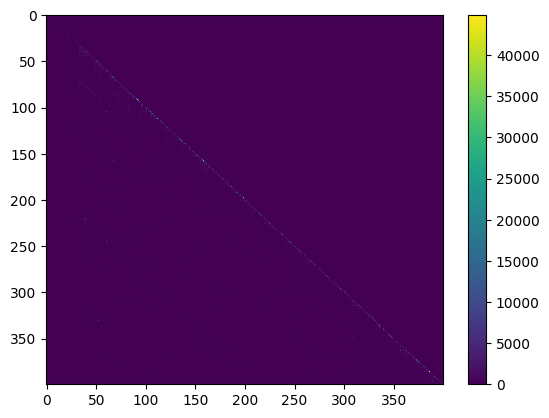

In [43]:
import matplotlib.pyplot as plt
song_id = 1
model.eval()
model.set_downsampled_path_enabled(True)
model.eval()
jacobian = model.get_jacobian(ds[song_id]['indices'][:400].unsqueeze(0).cuda(),ds[song_id]['pos'][:400+1].unsqueeze(0).cuda(),range(0,400))
plt.imshow((jacobian**2).max(dim=2).values.cpu().detach().numpy(),aspect='auto',interpolation='none')
plt.colorbar()



True

In [5]:
ds.ds.get_piano_roll(10).to_midi('output/test.mid')

ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

In [37]:
for i in range(1330,3000):
    print(i)
    pr = ds.ds.get_piano_roll(i)
    l = []
    for i in range(5):
        l.append(pr.notes[i].pitch)
    if len( {36, 48, 52, 55, 62} - set(l)) < 2:
        break


1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366


In [38]:
l

[36, 43, 48, 52, 55]

In [32]:
pr.to_midi('output/test.mid')

ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

In [39]:
import random


random.choice(['隨單','戰旗'])

'戰旗'

In [2]:
import torch.nn as nn
nn.transformerenco()

c:\Users\User\miniconda3\envs\gr\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, o